## Test fonction run exp

### 1. Imports

In [1]:

import torch
import stat_reliability_measure.config as config_
from importlib import reload
import matplotlib.pyplot as plt

In [2]:
import stat_reliability_measure.dev.torch_utils as t_u
import stat_reliability_measure.dev.torch_utils2 as t_u2
from stat_reliability_measure.dev.amls.amls_config import MLS_SMC_Config
import stat_reliability_measure.dev.utils as utils
import stat_reliability_measure.run_exp as run_exp
from stat_reliability_measure.config import ExpModelConfig
import stat_reliability_measure.dev.smc.smc_pyt as smc_pyt
import stat_reliability_measure.dev.smc.smc_pyt2 as smc_pyt2

import stat_reliability_measure.dev.smc.smc_config as smc_config
import stat_reliability_measure.dev.smc.smc_config2 as smc_config2

import stat_reliability_measure.dev.amls.amls_pyt as amls_pyt
import stat_reliability_measure.dev.form.form_pyt as form_pyt
import stat_reliability_measure.dev.amls.amls_config as amls_config 
import stat_reliability_measure.dev.mls.webb_config as webb_config
import stat_reliability_measure.dev.form.form_config as form_config
import stat_reliability_measure.dev.mls.amls_uniform as amls_webb
import stat_reliability_measure.dev.mc.mc_pyt as mc_pyt
import stat_reliability_measure.dev.mc.mc_config as mc_config
import stat_reliability_measure.dev.imp_sampling.is_pyt as is_pyt
import stat_reliability_measure.dev.imp_sampling.is_config as is_config
import stat_reliability_measure.dev.torch_arch as t_a

import pandas as pd
import numpy as np
import os 


### 2. Model & Data load

In [3]:
reload(config_)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
model = t_a.dnn2()
model.load_state_dict(torch.load('../models/mnist/model_dnn2_release.pt'))
model.to(device)
model.eval()

dnn2(
  (linear1): Linear(in_features=784, out_features=200, bias=True)
  (linear2): Linear(in_features=200, out_features=10, bias=True)
  (flat_op): Flatten()
)

In [5]:
config = ExpModelConfig(model=model,dataset_name='mnist',device=device,)

In [6]:
config.model

dnn2(
  (linear1): Linear(in_features=784, out_features=200, bias=True)
  (linear2): Linear(in_features=200, out_features=10, bias=True)
  (flat_op): Flatten()
)

In [7]:
config.update()
os.rmdir(config.exp_log_path)

In [8]:
X,y = config.X[:1], config.y[:1]

In [10]:
reload(t_u)

<module 'stat_reliability_measure.dev.torch_utils' from '/home/karimtito/repos/stat_reliability_measure/dev/torch_utils.py'>

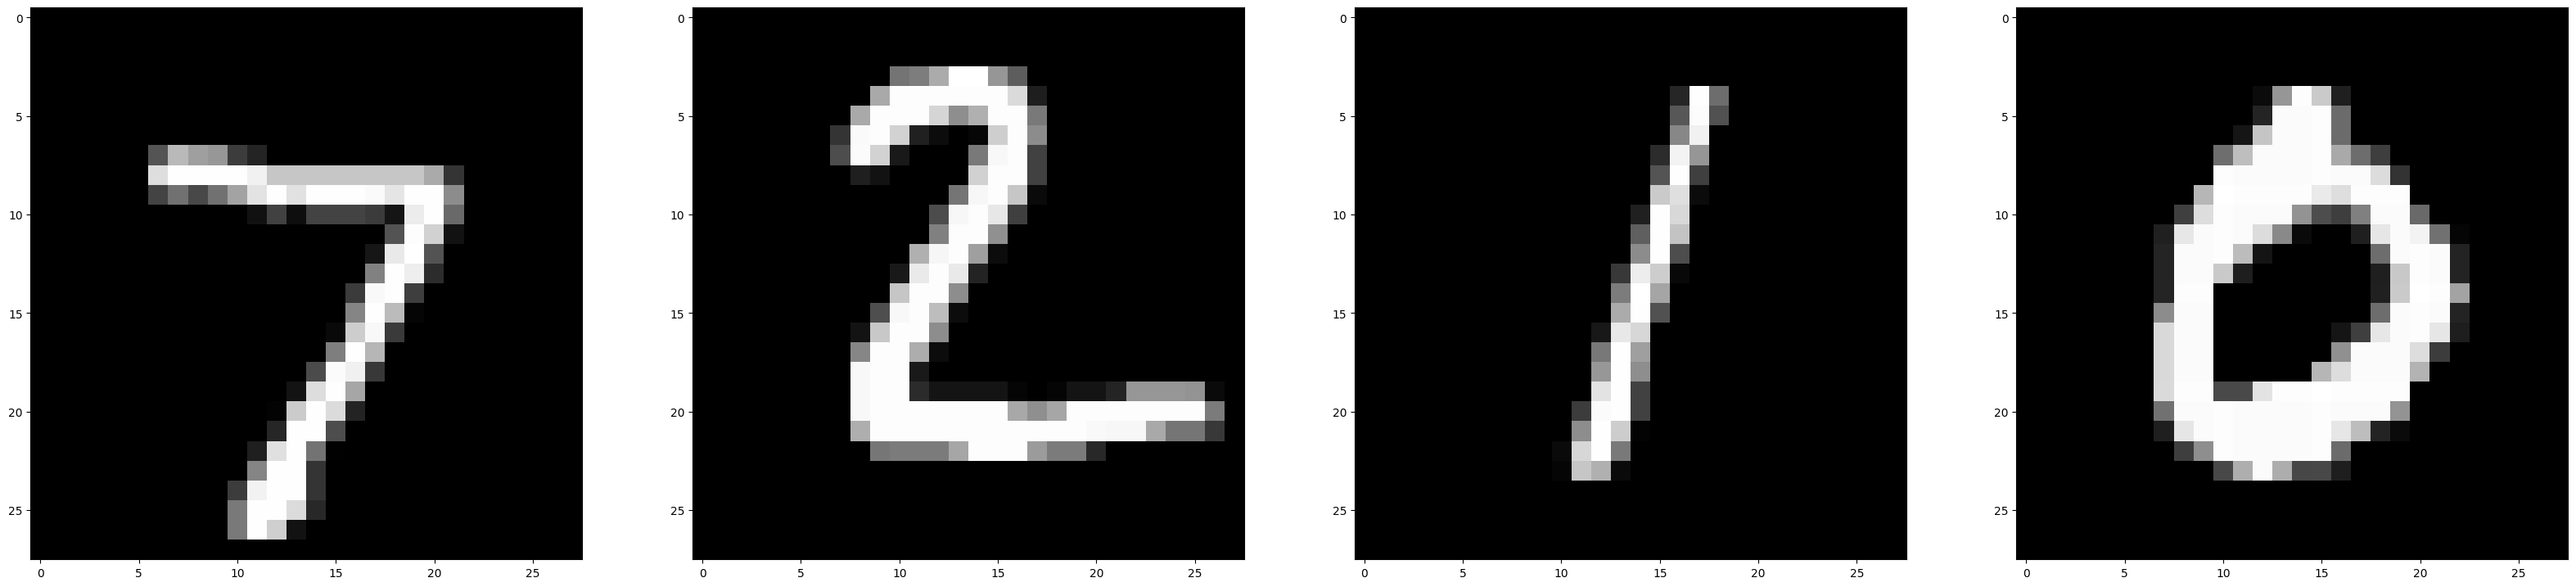

In [11]:
t_u.plot_k_tensor(config.X[:4])

In [12]:
config.sample_accuracy

0.9921875

## 3. Experiments with MALA-SMC, MLS-SMC, Importance Sampling, FORM and Line Sampling

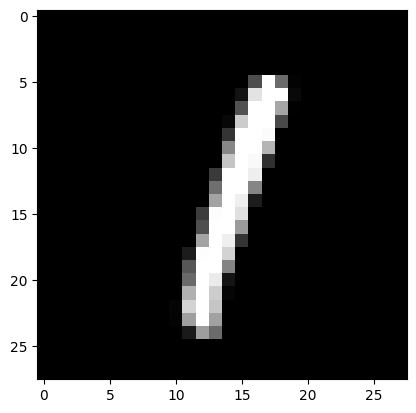

In [90]:
epsilon_range=[0.18]
dataset='cifar10'
n_rep = 100 
method_ref='mala2'
method_ref_name='MALA_SMC'
N_ref = 1000
T_ref = 20
ess_ref = 0.8
alpha_ref = 0.2
n_rep_ref = 400
input_index=5
agg_res_df = pd.read_csv('../logs/exp_model_mnist/aggr_res.csv')
exp_config = ExpModelConfig(model=model,dataset_name='mnist',device=device,input_start=input_index,epsilon_range=[0.18])
exp_config.update()
t_u.plot_tensor(exp_config.x_clean)

In [28]:
input_ = exp_config.x_clean
input_.requires_grad=True
input_ = input_.reshape(1,784)
s = t_u.score_function(X=input_,y_clean=exp_config.y_clean,model=exp_config.model)
u_normal=exp_config.gen(1)
u_normal.requires_grad=True
x_normal=exp_config.normal_cdf_layer(u_normal)
s_x = t_u.score_function(X=x_normal,y_clean=exp_config.y_clean,model=exp_config.model)


In [29]:
def G_(u):
    x= exp_config.normal_cdf_layer(u)
    G_x = -t_u.score_function(X=x,y_clean=exp_config.y_clean,model=exp_config.model)
    return G_x
    

In [30]:
def gram_schmidt(vv):
    def projection(u, v):
        return (v * u).sum() / (u * u).sum() * u

    nk = vv.size(0)
    uu = torch.zeros_like(vv, device=vv.device)
    uu[:, 0] = vv[:, 0].clone()
    for k in range(1, nk):
        vk = vv[k].clone()
        uk = 0
        for j in range(0, k):
            uj = uu[:, j].clone()
            uk = uk + projection(uj, vk)
        uu[:, k] = vk - uk
    for k in range(nk):
        uk = uu[:, k].clone()
        uu[:, k] = uk / uk.norm()
    return uu

def rotation_matrix(u):
    """constructs a rotation matrix such that the first coordinate axis is the direction of u, using gram-schmidt"""
    Q = torch.eye(u.shape[-1])
    Q[:,0] = u.squeeze(0)
    G = gram_schmidt(Q)
    R = G.t()

    return R 

In [31]:
N=128
k=18
X_normal = exp_config.gen(N)
dist_normal = torch.norm(X_normal,dim=-1)
G_X_normal = exp_config.G(X_normal)

percent_fail = (G_X_normal<=0).float().mean().item()
print(f"Percentage of failure in samples: {percent_fail}")
x_0 = exp_config.X[input_index:input_index+1]
index_topk = torch.topk(input=G_X_normal,k=k,largest=False, sorted=True).indices
print(f"h_score: {exp_config.h(X_normal)}")
print(f"h alt :{exp_config.h_alt(X_normal)}")
print(f"v_score: {exp_config.V(X_normal)}")
print(f"v score alt: {exp_config.V_alt(X_normal)}")

grad_v = exp_config.gradV(X_normal)[0][:2]

grad_v_alt = exp_config.gradV_alt(X_normal)[0][:2]

u = exp_config.normal_cdf_layer(X_normal.view(N,*exp_config.input_shape))
del X_normal
logits_u = exp_config.model(u)
y_pred = torch.argmax( logits_u,-1)
delta_img = u-exp_config.x_clean
u_best = u[index_topk]
y_pred_best=y_pred[index_topk]
del u
#stats about delta_img
print(delta_img.min().item(),delta_img.max().item())
del delta_img
print(f" (gradv_autodiff-gradv_analytical)/gradv_autodiff:{((grad_v_alt-grad_v)/grad_v_alt).abs().max().item(),((grad_v_alt-grad_v)/grad_v_alt).abs().mean().item()}")
del grad_v,grad_v_alt


Percentage of failure in samples: 0.0
h_score: tensor([-2.7671, -2.6453, -2.2508, -1.7725, -2.9109, -2.0493, -2.3955, -2.4346,
        -1.9993, -2.0572, -2.1969, -1.6911, -1.8290, -1.4840, -2.5000, -1.8811,
        -1.7258, -2.0695, -2.7023, -2.0196, -2.0064, -2.6998, -2.0960, -2.1653,
        -2.3942, -2.6374, -2.4682, -3.2947, -2.8140, -2.0389, -2.5468, -2.2998,
        -3.2413, -2.1070, -2.0846, -2.2341, -2.0248, -2.2534, -1.5825, -2.0846,
        -2.2536, -2.6608, -2.2493, -2.6512, -2.2572, -2.3683, -1.8973, -2.2771,
        -2.1299, -2.7821, -1.9958, -1.6119, -2.0005, -1.6509, -2.4205, -2.2497,
        -2.2632, -2.6245, -2.5709, -2.1836, -3.0907, -2.3098, -2.2495, -2.5869,
        -2.4610, -2.4164, -1.8103, -2.2808, -2.3163, -1.7198, -1.9733, -1.8359,
        -2.4132, -1.4983, -2.9200, -2.6869, -2.0670, -2.2578, -2.3900, -2.3677,
        -2.3734, -2.6166, -2.7082, -2.1466, -1.9472, -1.2313, -2.4584, -2.2912,
        -1.3316, -2.2389, -1.8894, -1.7055, -3.0419, -2.1704, -2.7444, -2

/home/karimtito/venvs/deep_l/lib/python3.10/site-packages/foolbox/models/pytorch.py:36: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  warnings.warn(


Distances between LInf x_clean and x_attack: 

dist_linf_carlini: 0.09556156396865845
dist_linf_fmnal2: 0.12983562052249908
dist_linf_fmnal2_pp: 0.13015525043010712
dist_linf_mpp: 0.16676950454711914
Norms of the corresponding latent variables: 

norm_x_attack: 9.971149444580078
norm_x_fmnal2: 7.741934299468994
norm_x_fmnal2_pp: 7.775325298309326
norm_x_mpp: 10.610237121582031
G values of the different attacks: 

G_x_attack: -4.76837158203125e-07
G_x_fmnal2: -0.1255483627319336
G_x_fmnal2_pp: -0.14758777618408203
G_x_mpp: -1.7852320671081543
Time of the different attacks: 

time_carlini: 0.8939204216003418
time_mpp: 0.09459614753723145
time_fmnal2: 0.16937041282653809
time_fmnal2_pp: 1.9889061450958252
Form of the different attacks: 

form_attack: 1.0192788298501904e-23
form_fmna: 4.8957793423100444e-15
form_mpp: 1.3353521247239152e-26
form_fmna_pp: 3.762688487238607e-15


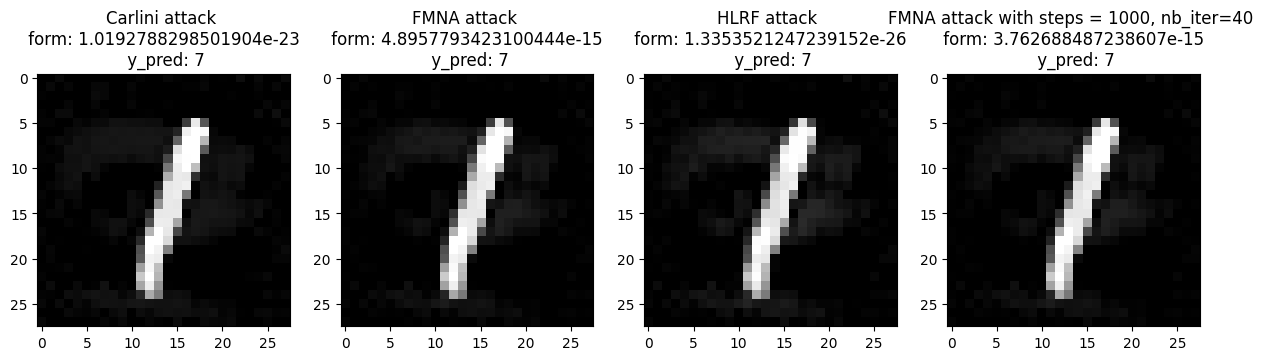

In [59]:
from time import time
import scipy.stats as stats
time_start = time()
x_attack= is_pyt.gaussian_space_attack(x_clean=exp_config.x_clean,y_clean=exp_config.y_clean,model=exp_config.model, normal_cdf_layer=exp_config.normal_cdf_layer,attack='Carlini',
                                       random_init=False).reshape((1,exp_config.d))
time_carlini = time()-time_start
dist_attack=torch.norm(x_attack).item()

form_attack=stats.norm.cdf(-dist_attack)
u_carlini=exp_config.normal_cdf_layer(x_attack)

y_pred_attack=torch.argmax(exp_config.model(u_carlini)).item()
y_carlini_text = t_u.imagenet_simple_labels[y_pred_attack]
dist_linf_carlini = (u_carlini-exp_config.x_clean).abs().max()
zero_latent=torch.zeros_like(x_attack).detach()
time_start = time()
x_mpp,nb_calls_mpp = is_pyt.mpp_search(grad_f= exp_config.gradG_alt, zero_latent=zero_latent, max_iter=100, stop_cond_type='beta' )
time_mpp = time()-time_start
form_mpp = stats.norm.cdf(-torch.norm(x_mpp).item())
u_mpp = exp_config.normal_cdf_layer(x_mpp)
y_mpp = torch.argmax(exp_config.model(u_mpp)).item()
y_mpp_text = t_u.imagenet_simple_labels[y_mpp]
dist_linf_mpp = (u_mpp-exp_config.x_clean).abs().max()
import foolbox as fb
fake_bounds = (-10,10)
total_model=torch.nn.Sequential(exp_config.normal_cdf_layer,exp_config.model)
fmodel=fb.models.PyTorchModel(model=exp_config.model, bounds = (0,1),)
total_fmodel=fb.models.PyTorchModel(model=total_model, bounds = fake_bounds,)
criterion = fb.criteria.Misclassification(exp_config.y_clean.unsqueeze(0))
time_start = time()

steps = 100
nb_iter = 20
zero_latent=torch.zeros_like(x_attack).detach()
fmnal2_attaack = fb.attacks.L2FMNAttack(steps = steps, binary_search_steps=nb_iter)

time_start = time()
x_fmnal2,_,_ = fmnal2_attaack(total_fmodel, zero_latent,exp_config.y_clean.unsqueeze(0),epsilons=[0.2])
time_fmnal2 = time()-time_start
x_fmnal2 = x_fmnal2[0].detach().reshape((1,exp_config.d))
form_fmna = stats.norm.cdf(-torch.norm(x_fmnal2).item())
u_fmnal2 = exp_config.normal_cdf_layer(x_fmnal2)
y_fmna = torch.argmax(exp_config.model(u_fmnal2)).item()
dist_linf_fmnal2 = (u_fmnal2-exp_config.x_clean).abs().max()



steps_pp = 1000
nb_iter_pp = 40
zero_latent=torch.zeros_like(x_attack).detach()
fmnal2_attaack = fb.attacks.L2FMNAttack(steps = steps_pp, binary_search_steps=nb_iter_pp)

time_start = time()
x_fmnal2_pp,_,_ = fmnal2_attaack(total_fmodel, zero_latent,exp_config.y_clean.unsqueeze(0),epsilons=[0.2])
time_fmnal2_pp = time()-time_start
x_fmnal2_pp = x_fmnal2_pp[0].detach().reshape((1,exp_config.d))
form_fmna_pp = stats.norm.cdf(-torch.norm(x_fmnal2_pp).item())
u_fmnal2_pp = exp_config.normal_cdf_layer(x_fmnal2_pp)
y_fmna_pp = torch.argmax(exp_config.model(u_fmnal2_pp)).item()
dist_linf_fmnal2_pp = (u_fmnal2_pp-exp_config.x_clean).abs().max()





#print the different attacks distances 
print(f"Distances between LInf x_clean and x_attack: \n")
print(f"dist_linf_carlini: {dist_linf_carlini.item()}")
print(f"dist_linf_fmnal2: {dist_linf_fmnal2.item()}")
print(f"dist_linf_fmnal2_pp: {dist_linf_fmnal2_pp.item()}")
print(f"dist_linf_mpp: {dist_linf_mpp.item()}")



print(f"Norms of the corresponding latent variables: \n")
print(f"norm_x_attack: {torch.norm(x_attack).item()}")
print(f"norm_x_fmnal2: {torch.norm(x_fmnal2).item()}")
print(f"norm_x_fmnal2_pp: {torch.norm(x_fmnal2_pp).item()}")
print(f"norm_x_mpp: {torch.norm(x_mpp).item()}")




#print the G values of the different attacks
print(f"G values of the different attacks: \n")
print(f"G_x_attack: {exp_config.G_alt(x_attack).item()}")
print(f"G_x_fmnal2: {exp_config.G_alt(x_fmnal2).item()}")
print(f"G_x_fmnal2_pp: {exp_config.G_alt(x_fmnal2_pp).item()}")
print(f"G_x_mpp: {exp_config.G_alt(x_mpp).item()}")



#print the time of the different attacks
print(f"Time of the different attacks: \n")
print(f"time_carlini: {time_carlini}")
print(f"time_mpp: {time_mpp}")
print(f"time_fmnal2: {time_fmnal2}")
print(f"time_fmnal2_pp: {time_fmnal2_pp}")

#print the form of the different attacks
print(f"Form of the different attacks: \n")
print(f"form_attack: {form_attack}")
print(f"form_fmna: {form_fmna}")
print(f"form_mpp: {form_mpp}")
print(f"form_fmna_pp: {form_fmna_pp}")

#plot the different attacks
plt.figure(figsize=(15,20))
plt.subplot(1,4,1)
plt.imshow(u_carlini[0].detach().cpu().numpy().transpose((1,2,0)),cmap='gray')
plt.title(f"Carlini attack \n form: {form_attack} \n y_pred: {y_pred_attack}")
plt.subplot(1,4,2)

plt.imshow(u_fmnal2[0].detach().cpu().numpy().transpose((1,2,0)),cmap='gray')
plt.title(f"FMNA attack \n form: {form_fmna} \n y_pred: {y_fmna}")


plt.subplot(1,4,3)
plt.imshow(u_mpp[0].detach().cpu().numpy().transpose((1,2,0)),cmap='gray')
plt.title(f"HLRF attack \n form: {form_mpp} \n y_pred: {y_mpp}")


plt.subplot(1,4,4)
plt.imshow(u_fmnal2_pp[0].detach().cpu().numpy().transpose((1,2,0)),cmap='gray')
plt.title(f"FMNA attack with steps = {steps_pp}, nb_iter={nb_iter_pp} \n form: {form_fmna_pp} \n y_pred: {y_fmna_pp}")
plt.show()


FORM/SORM comparison for Carlini attack
P_FORM = 1.0192788298501904e-23
P_SORM = 6.17117441132839e-14
P_sorm_HR = 8.135472718699653e-25


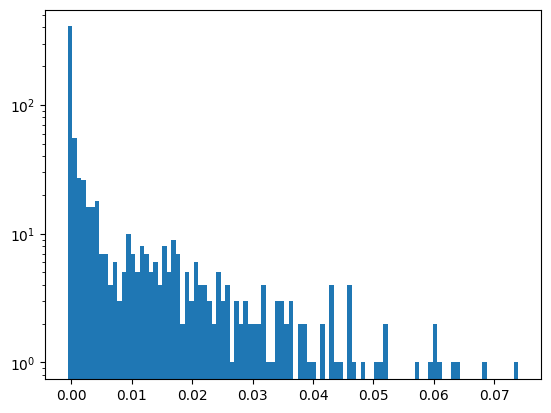

FORM/SORM comparison for HLRF attack
P_FORM = 1.3353521247239152e-26
P_SORM = 2.694111320277891e-15
P_sorm_HR = 8.156066795447062e-28


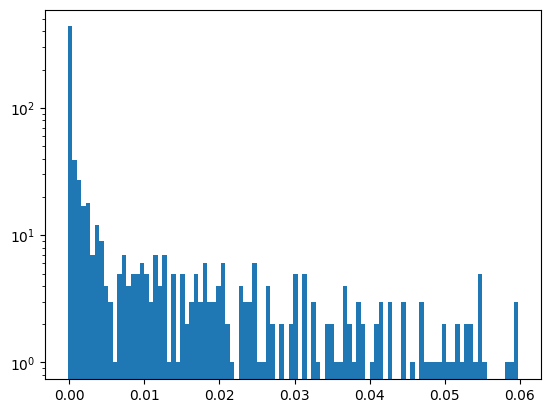

FORM/SORM comparison for FMNA attack
P_FORM = 4.8957793423100444e-15
P_SORM = 1.6178699979718658e-07
P_sorm_HR = 4.173816522182037e-16


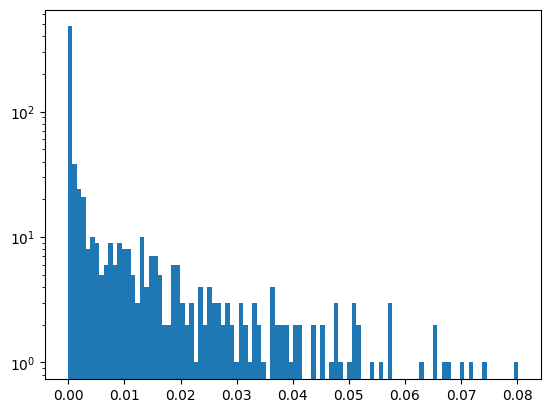

In [62]:
for u,attack_name in zip([x_attack,x_mpp,x_fmnal2],['Carlini','HLRF','FMNA']):
    print(f"FORM/SORM comparison for {attack_name} attack")
    grad_G = torch.autograd.functional.jacobian(func=G_,inputs=u,)
    grad_norm = grad_G.norm()
    u_norm= u_normal.norm()
    beta = u_norm 
    hess_G = torch.autograd.functional.hessian(func=G_,inputs=u)
    mat_hess_G=hess_G.squeeze((0,2))

    R=rotation_matrix(u).to(device
                                )
    A = R@mat_hess_G@R.t()
    A_tilde = A[1:,1:]/grad_norm
    eigvals = torch.linalg.eigvals(mat_hess_G).float()
    sum_eigvals = eigvals.sum()
    sum_abs_eigvals = eigvals.abs().sum()

    top_eigvals = eigvals.abs().topk(k=300).values
    beta_attack = u.norm().item()

    P_FORM = stats.norm.cdf(-beta_attack)
    def p_sorm_base(beta,kappas):
        form = stats.norm.cdf(-beta)
        factor = torch.prod(torch.sqrt(1+beta*kappas))
        return form*factor

    def psi(x): 
        return stats.norm.pdf(x)/stats.norm.pdf(-x)
    def p_sorm_HR(beta,kappas): 
        form = stats.norm.cdf(-beta)    
        factor = torch.prod(1/torch.sqrt(1+psi(beta)*kappas))
        return form*factor
    def p_sorm(beta,kappas):
        form = stats.norm.cdf(-beta)
        factor = torch.prod(torch.sqrt(1+beta*kappas))
        return form*factor
    P_sorm_HR = p_sorm_HR(beta_attack,eigvals)
    P_SORM = p_sorm(beta_attack,eigvals)

    print(f"P_FORM = {P_FORM}")
    print(f"P_SORM = {P_SORM}")
    print(f"P_sorm_HR = {P_sorm_HR}")
    # print(f"sum abs eigvals = {sum_abs_eigvals}")
    # print(f"sum eigvals = {sum_eigvals}")
    # print(f"top eigvals = {top_eigvals}")
    # print(f"ratio = {top_eigvals.sum()/sum_abs_eigvals}")
    plt.hist(eigvals.cpu().numpy(),bins=100)
    plt.yscale('log')
    plt.show()


In [147]:
def binary_search_to_zero(G,x,lambda_min=0.,lambda_max=4.,eps=1e-3, max_iter=100,thresh=1e-3):
    """binary search to find the zero of a function"""
    
    i=0
    if G(x)>0:
        
        a = 1
        b = lambda_max

        c = (a+b)/2

        while G(c*x).abs()>eps and max_iter<i:
            i+=1
            G_c = G(c*x)
            print(f"c={c},G_c={G_c}")
            if G(c*x)>0:
                a = c
            else:
                b = c
            c = (a+b)/2
    else:
        a = lambda_min
        b = 1
        c = (a+b)/2
   
        while G(c*x)>0 and max_iter<i:
            i+=1
            G_c = G(c*x)
            print(f"c={c},G_c={G_c}")
            if G(c*x)>0:
                a = c
            else:
                b = c
            c = (a+b)/2
    return c

In [148]:
exp_config.G(1.0*x_mpp)

tensor([-0.6463], device='cuda:0')

In [174]:
lambda_=binary_search_to_zero(G=exp_config.G_alt,x=x_mpp)
real_x_attack = lambda_*x_mpp
print(f"G(real_x_mpp)={exp_config.G(real_x_attack)}")
print(f"norm real_x_mpp={torch.norm(real_x_attack)}")

c=0.5,G_c=tensor([1.6476], device='cuda:0')
c=0.75,G_c=tensor([0.0699], device='cuda:0')
c=0.875,G_c=tensor([-0.6035], device='cuda:0')
c=0.8125,G_c=tensor([-0.2768], device='cuda:0')
c=0.78125,G_c=tensor([-0.1057], device='cuda:0')
c=0.765625,G_c=tensor([-0.0185], device='cuda:0')
c=0.7578125,G_c=tensor([0.0256], device='cuda:0')
c=0.76171875,G_c=tensor([0.0035], device='cuda:0')
c=0.763671875,G_c=tensor([-0.0075], device='cuda:0')
c=0.7626953125,G_c=tensor([-0.0020], device='cuda:0')
G(real_x_mpp)=tensor([0.0984], device='cuda:0')
norm real_x_mpp=9.131903648376465


In [175]:
lambda_=binary_search_to_zero(G=exp_config.G_alt,x=x_attack)
real_x_attack = lambda_*x_attack
print(f"G(real_x_attack)={exp_config.G(real_x_attack)}")
print(f"norm real_x_attack={torch.norm(real_x_attack)}")

c=0.5,G_c=tensor([2.5865], device='cuda:0')
c=0.75,G_c=tensor([1.2510], device='cuda:0')
c=0.875,G_c=tensor([0.6092], device='cuda:0')
c=0.9375,G_c=tensor([0.3001], device='cuda:0')
c=0.96875,G_c=tensor([0.1489], device='cuda:0')
c=0.984375,G_c=tensor([0.0739], device='cuda:0')
c=0.9921875,G_c=tensor([0.0369], device='cuda:0')
c=0.99609375,G_c=tensor([0.0185], device='cuda:0')
c=0.998046875,G_c=tensor([0.0092], device='cuda:0')
c=0.9990234375,G_c=tensor([0.0046], device='cuda:0')
G(real_x_attack)=tensor([-0.9233], device='cuda:0')
norm real_x_attack=10.766273498535156


In [28]:
v_no_atom=exp_config.V(u)

In [29]:
v_alt=exp_config.V_alt(u)

with parameters in {'N_range': [1000], 'T_range': [20], 'ess_alpha_range': [0.8], 'alpha_range': [0.2], 'L_range': [1]}
Experiment already done for method: MALA_SMC
Starting MALA_SMC simulation 1/1, with model: model, img_idx:5,eps:0.18, N: 1000: T: 20: ess_alpha: 0.8: alpha: 0.2: L: 1


100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


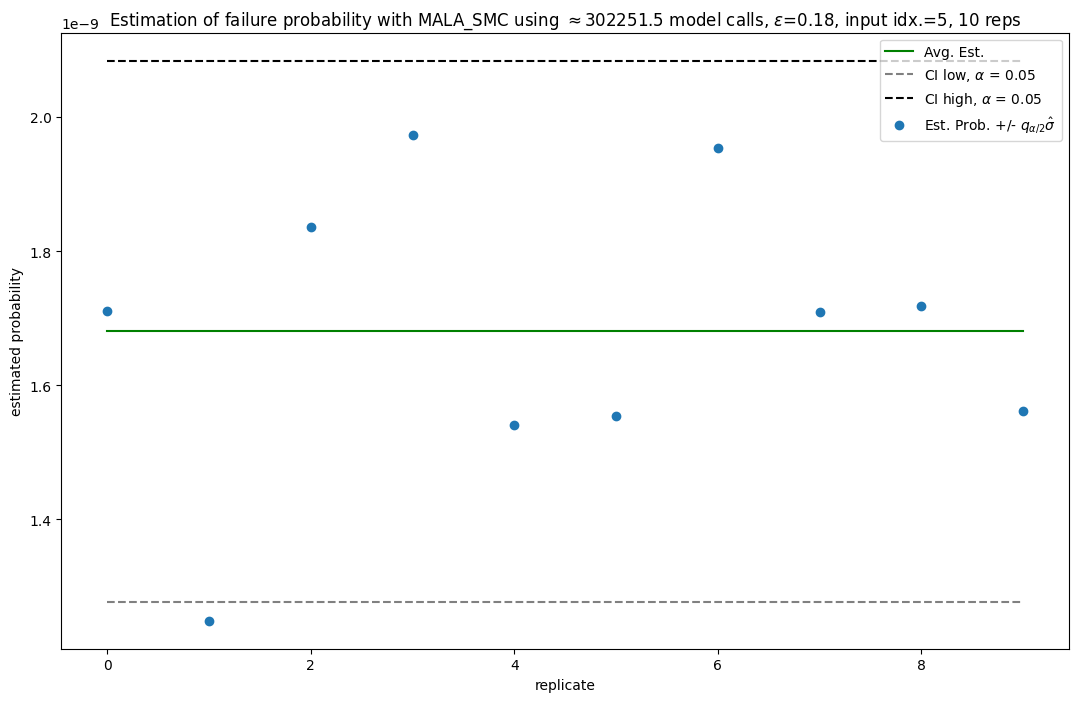

mean est:1.6804630020850197e-09, std est:2.0590546939320618e-10
mean calls:302251.5
std. re.:72913840.22421639
std. rel. adj.:22038317578529.74


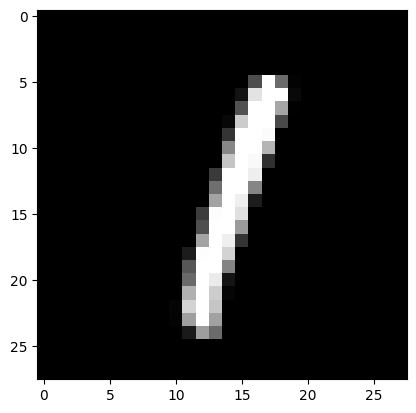

In [95]:
input_index=5
p_ref, dict_out = run_exp.run_est(model=exp_config.model,X=exp_config.X,y=exp_config.y,noise_dist ='uniform',
                                                repeat_exp=False, track_dt=False,input_start=input_index,
                                                input_stop=input_index+1,
                                             method='mala2', dataset_name='mnist',
                                             n_rep=10, verbose=0,
                                epsilon_range=exp_config.epsilon_range, update_aggr_res=True ,
                                track_accept=False,
                                N_range=[N_ref], T_range =[T_ref],ess_alpha = ess_ref,
                                alpha=alpha_ref)

c= dict_out['exp_config']
t_u.plot_tensor(c.x_clean)

/tmp/ipykernel_5343/92554365.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_data['mean_log10_est'] = ref_data['mean_log_est']/np.log(10)
/tmp/ipykernel_5343/92554365.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_data['std_log10_est'] = ref_data['std_log_est']/np.log(10)


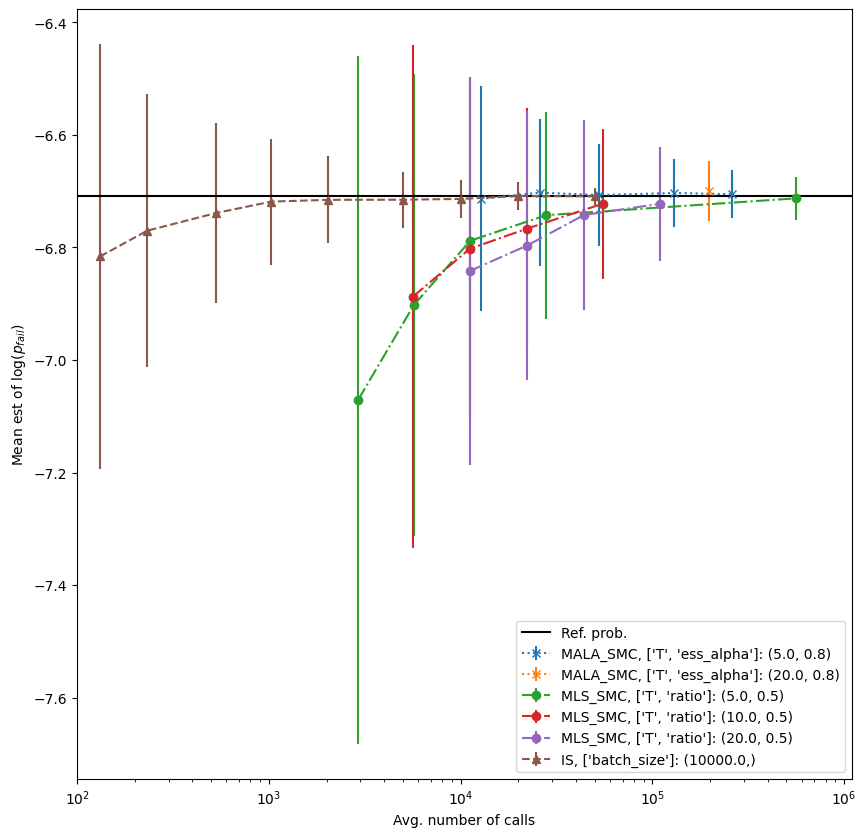

In [37]:
ref_data = utils.get_sel_df(agg_res_df,triplets=[('n_rep',n_rep_ref,'='),('epsilon',epsilon_range[0],'='),])
param_methods_dict = {'MLS_SMC':['T','N','alpha','ess_alpha'],
                      'MALA_SMC':['T','N','alpha','ess_alpha'],
                      'IS':['N','batch_size'],}
param_methods_ex_N = {'IS':['batch_size'],
                      'MLS_SMC':['T','ratio',],
                      'MALA_SMC':['T','ess_alpha',],
                      }
cond_methods_dict = {'MLS_SMC':[('T',5,'>='),('N',2,'>='),('ratio',0.5,'=='),('T',100,'<='),],
                     'MALA_SMC':[('T',5,'>='),('N',2,'>='),('ess_alpha',0.8,'=='),('T',100,'<=')],
                        'IS':[('batch_size',int(1e4),'==')],
                                }

calls_max = 1e6
max_exp_by_method=3
ref_data['mean_log10_est'] = ref_data['mean_log_est']/np.log(10)
ref_data['std_log10_est'] = ref_data['std_log_est']/np.log(10)
mode_y = 'log10' 
x_variable = 'mean_calls'
if mode_y == 'log10':
    y_variable= 'mean_log10_est'
    y_error = 'std_log10_est'
    
elif mode_y == 'log':
    y_variable= 'mean_log_est'
    y_error = 'std_log_est'
else:
    y_variable= 'mean_est'
    y_error = 'std_est'
methods_grouped={}
max_calls=0
plot_traits = {'MLS_SMC':{'marker':'o','linestyle':'-.',},
               'MALA_SMC':{'marker':'x','linestyle':':',},
                'IS':{'marker':'^','linestyle':'--'},
                }

min_calls = 1e10
plt.figure(figsize=(10,10),)
for method in ref_data['method_name'].unique():
    cond_method = cond_methods_dict[method]
    method_df = utils.get_sel_df(ref_data,triplets=[('method_name',method,'=')]+cond_method+[(x_variable,calls_max,'<=')])
    params = param_methods_ex_N[method]
    method_df_grouped = method_df.groupby(params)
    methods_grouped[method] = list(method_df_grouped)
    i = 0
    for values,df in method_df_grouped:
        if i > max_exp_by_method:
            break
        df = df .drop_duplicates(subset=['N'])
        df = df.sort_values(by=x_variable)
        
        log_mean_calls = np.log(df[x_variable].values)
        plt.errorbar(df[x_variable],df[y_variable],yerr=df[y_error],
                     label=f"{method}, {params}: {values}",**plot_traits[method])
        plt.xscale('log')
        plt.ylabel(r'Mean est of $\log(p_{fail})$')
        plt.xlabel('Avg. number of calls')
        
        i+=1
        max_calls=max(max_calls,df[x_variable].max())
        min_calls = min(min_calls,df[x_variable].min())
if p_ref is not None:
    #using a different marker and linestyle for the reference method
    plt.axhline(y=np.log10(p_ref),label='Ref. prob.',color='k',linestyle='-')
plt.xlim([1e2,1.1e6])
plt.legend(loc='lower right')
    # for params_value in method_df[params].unique():
    #     print(f"method: {method}, params: {params}, params_value: {params_value}")
    # param_df = param_df.sort_values(by=x_variable)
    # plt.errorbar(param_df[x_variable],param_df['mean_est'],yerr=param_df[y_error],label=param)


In [41]:
reload(amls_config)
reload(config_)
reload(webb_config)
reload(amls_webb)
reload(amls_pyt)
reload(smc_pyt)
reload(smc_pyt2)
reload(smc_config2)
reload(t_u2)
reload(run_exp)
reload(form_config)
reload(t_u)
reload(form_pyt)
reload(is_pyt)
reload(is_config)
reload(mc_config)
reload(mc_pyt)

<module 'stat_reliability_measure.dev.mc.mc_pyt' from '/home/karimtito/repos/stat_reliability_measure/dev/mc/mc_pyt.py'>

In [67]:
p_fail_form,dict_out_form = run_exp.run_est(model=model,X=X,y=y,method='form',dataset_name='mnist',random_init=True,n_rep=5, epsilon_range=epsilon_range,
                                            sigma_init=0.00,  stepsize=0.1,
                                            steps=40,num_iter=500 ,repeat_exp=False, real_uniform=True, p_ref=p_ref, update_aggr_res=True,)


NameError: name 'p_ref' is not defined

In [71]:
reload(run_exp)

<module 'stat_reliability_measure.run_exp' from '/home/karimtito/repos/stat_reliability_measure/run_exp.py'>

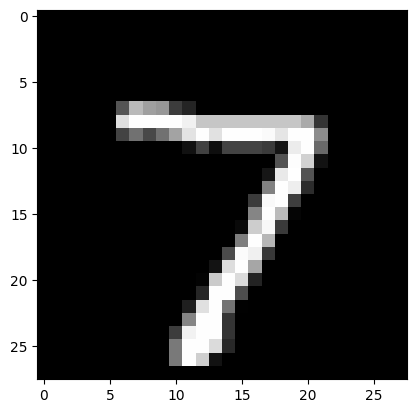

In [77]:
t_u.plot_tensor(exp_config.X)

In [73]:
N_range_low = [50,100,200,500]
N_range_high = [1000,2000,5000,10000]
N_range = N_range_low + N_range_high

p_fail_mala, dict_out=run_exp.run_est(model=exp_config.model,method='mala2',X=exp_config.X,y=exp_config.y,dataset_name='mnist',
                        n_rep=40, verbose=0, track_accept=False,ess_alpha_range=[0.8], input_start=input_index,input_stop=input_index+1,
                        alpha=0.25, L_range=[1], only_duplicated=False,
                         N=100,T_range=[5],epsilon_range=exp_config.epsilon_range,
                         repeat_exp=True,
 )


exp_config,method_config_mala, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_df_mala = dict_out['results_df']
print(f"p_fail_mala={p_fail_mala}")

IndexError: index 5 is out of bounds for dimension 0 with size 1

Files already downloaded and verified
with parameters in {'N_range': [50, 100, 200, 500], 'T_range': [2, 5, 10, 20], 'ratio_range': [0.5], 's_range': [1.0]}
Starting MLS_SMC simulation 1/16, with model: model, img_idx:5,eps:0.18, N: 50: T: 2: ratio: 0.5: s: 1.0


100%|██████████| 400/400 [00:17<00:00, 22.95it/s]


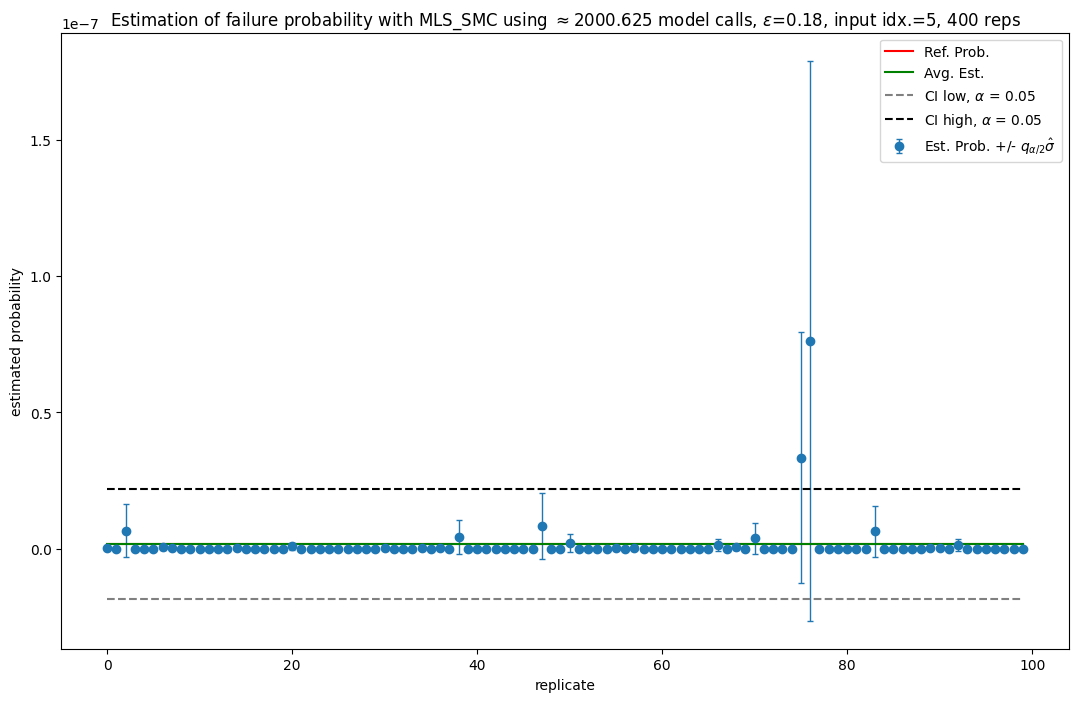

mean est:1.8061617885505016e-09, std est:1.029109035354903e-08
mean calls:2000.625
std. re.:3154627545.4891057
std. rel. adj.:6311226733194.143
mean rel. error:1.826636462552857
std rel. error:5.845673273405117
stat performance (per 1k calls):11.695000092606112
Starting MLS_SMC simulation 2/16, with model: model, img_idx:5,eps:0.18, N: 50: T: 5: ratio: 0.5: s: 1.0


100%|██████████| 400/400 [00:28<00:00, 14.15it/s]


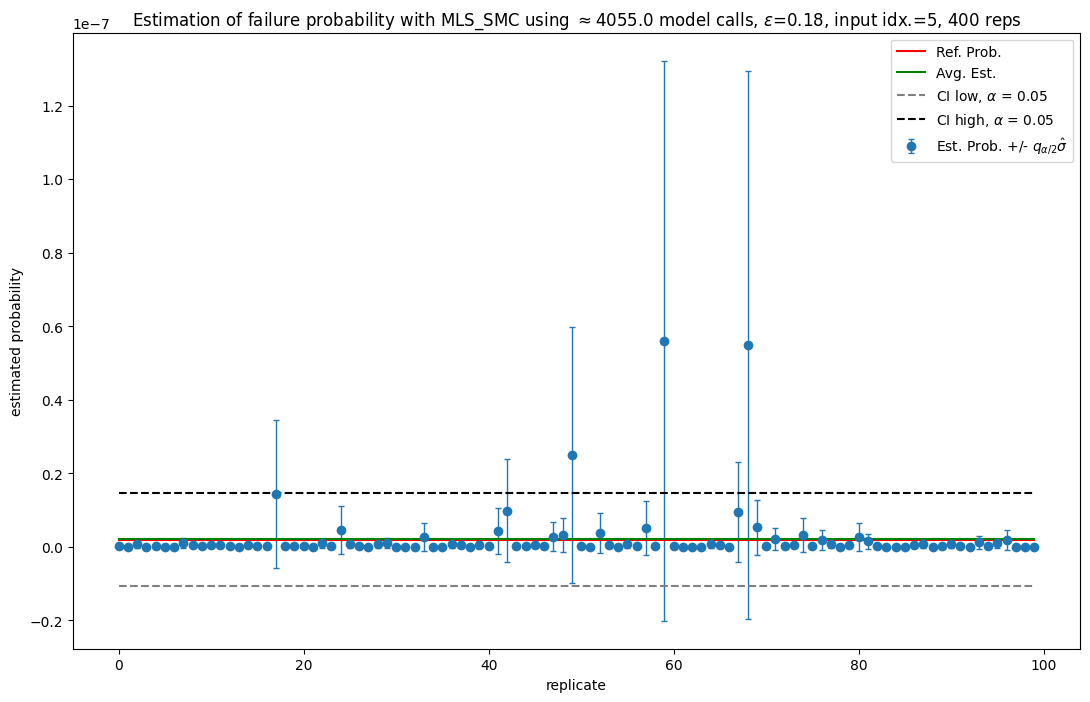

mean est:2.0226541342704963e-09, std est:6.454963885936651e-09
mean calls:4055.0
std. re.:1577794957.702565
std. rel. adj.:6397958553483.901
mean rel. error:1.5132037765710116
std rel. error:3.5364327637022703
stat performance (per 1k calls):14.340234856812705
Starting MLS_SMC simulation 3/16, with model: model, img_idx:5,eps:0.18, N: 50: T: 10: ratio: 0.5: s: 1.0


100%|██████████| 400/400 [00:48<00:00,  8.17it/s]


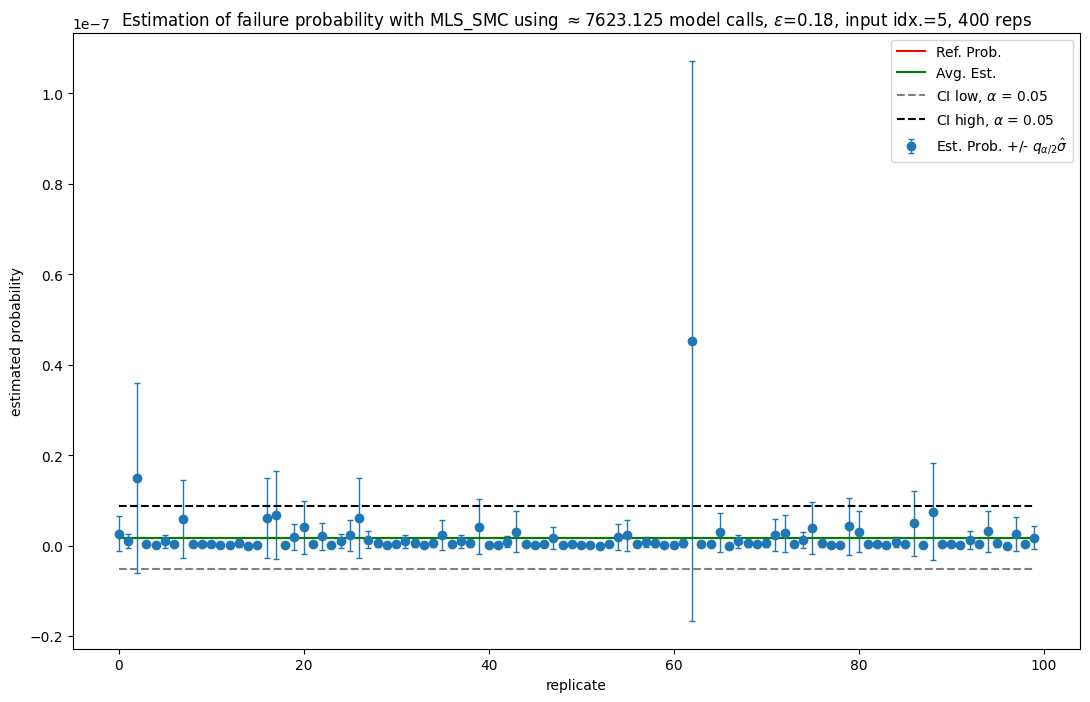

mean est:1.7732269952830393e-09, std est:3.5354114211968456e-09
mean calls:7623.125
std. re.:1124375288.1474335
std. rel. adj.:8571253368458.904
mean rel. error:1.1195360164906203
std rel. error:1.7820758532896566
stat performance (per 1k calls):13.584986989108714
Starting MLS_SMC simulation 4/16, with model: model, img_idx:5,eps:0.18, N: 50: T: 20: ratio: 0.5: s: 1.0


100%|██████████| 400/400 [01:39<00:00,  4.04it/s]


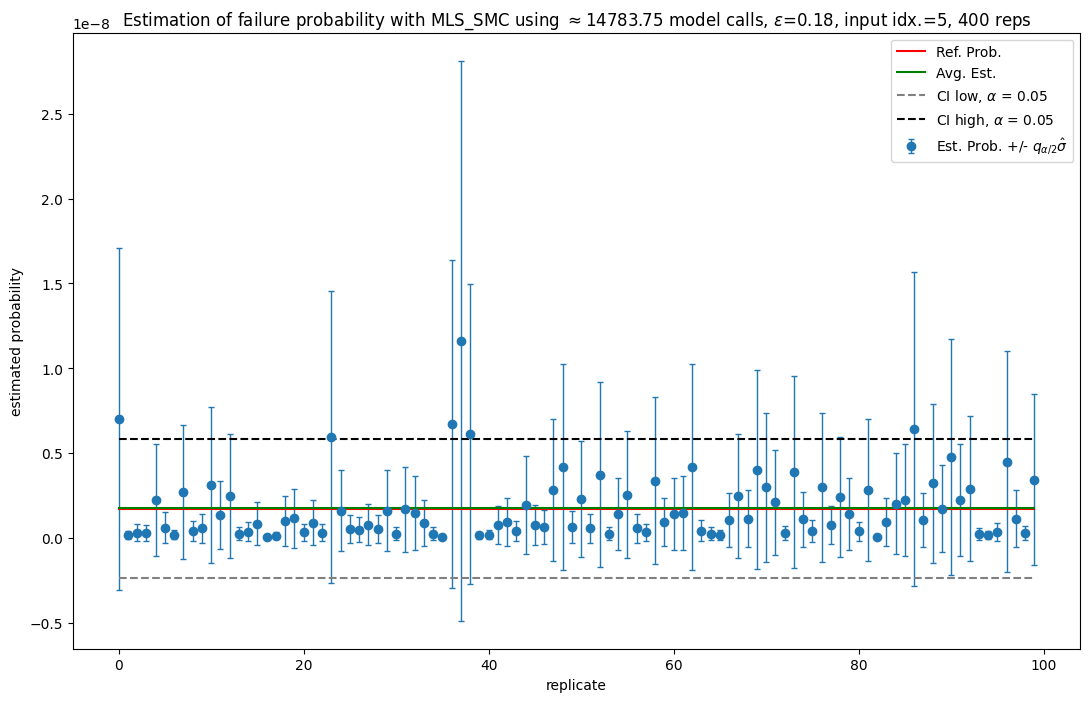

mean est:1.7304293578490614e-09, std est:2.0853321841696265e-09
mean calls:14783.75
std. re.:696414005.9310435
std. rel. adj.:10295610560183.064
mean rel. error:0.8010924362774275
std rel. error:0.9481746791096429
stat performance (per 1k calls):14.017577412287183
Starting MLS_SMC simulation 5/16, with model: model, img_idx:5,eps:0.18, N: 100: T: 2: ratio: 0.5: s: 1.0


100%|██████████| 400/400 [00:14<00:00, 28.04it/s]


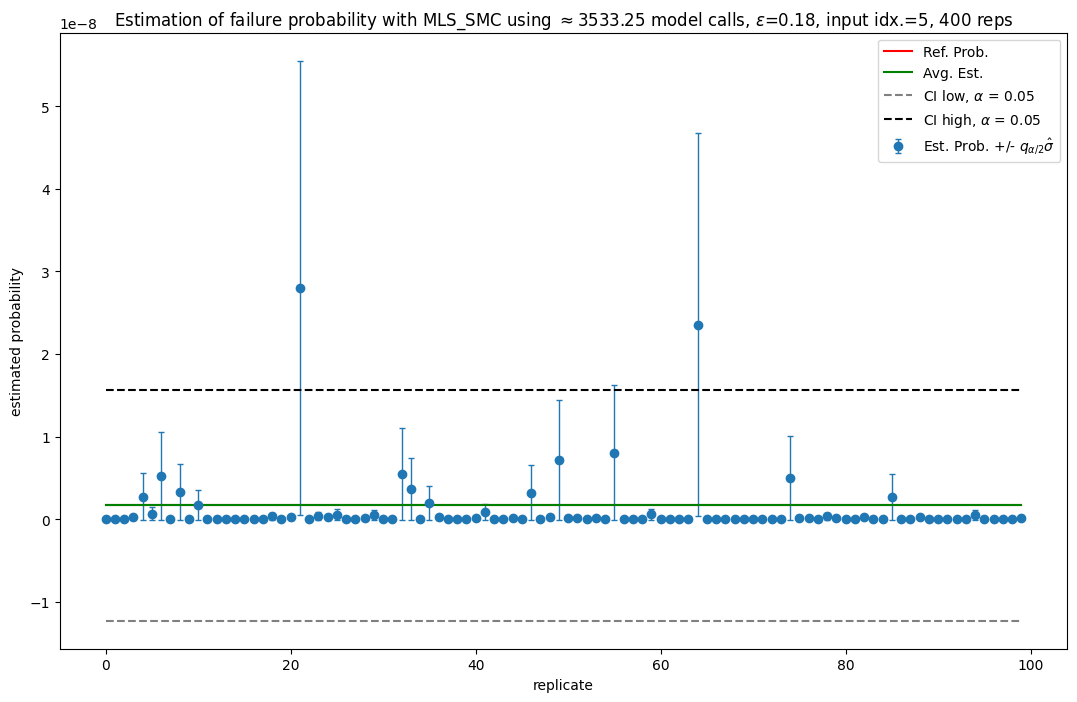

mean est:1.677405883457328e-09, std est:7.1170763897741e-09
mean calls:3533.25
std. re.:2529445365.5062795
std. rel. adj.:8937162837675.062
mean rel. error:1.5438699284359785
std rel. error:3.943765279428533
stat performance (per 1k calls):13.934308673540864
Starting MLS_SMC simulation 6/16, with model: model, img_idx:5,eps:0.18, N: 100: T: 5: ratio: 0.5: s: 1.0


100%|██████████| 400/400 [00:29<00:00, 13.60it/s]


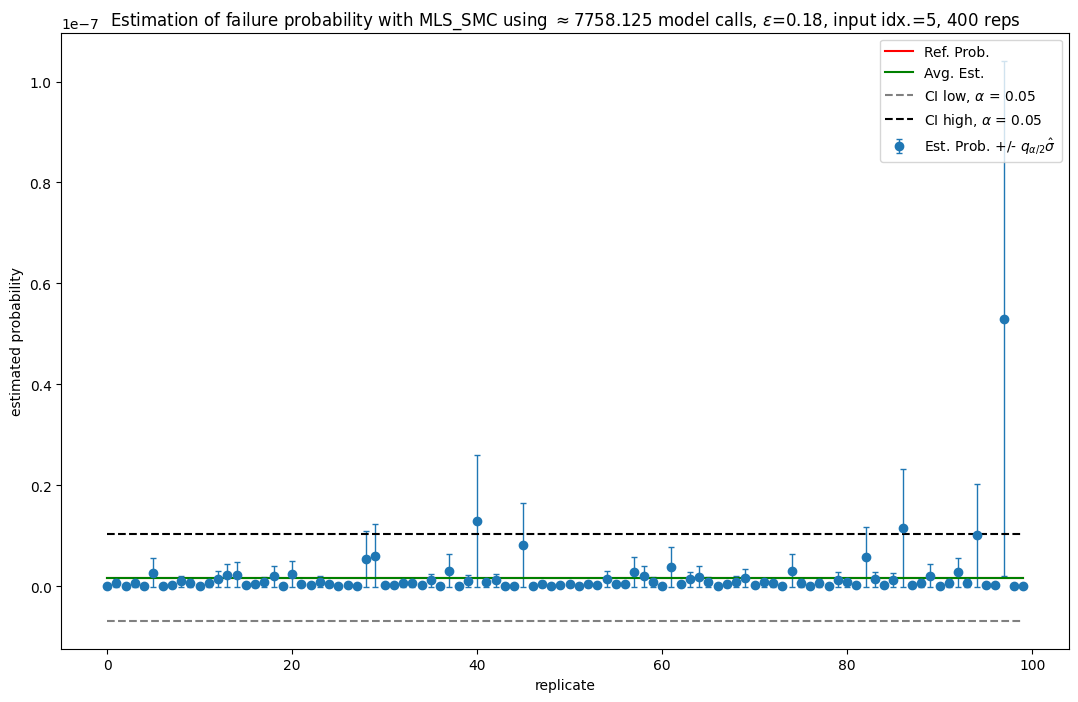

mean est:1.762336228239292e-09, std est:4.359474209726814e-09
mean calls:7758.125
std. re.:1403642710.4918284
std. rel. adj.:10889635603334.416
mean rel. error:1.183929828191236
std rel. error:2.3088114402422897
stat performance (per 1k calls):17.912047754829715
Starting MLS_SMC simulation 7/16, with model: model, img_idx:5,eps:0.18, N: 100: T: 10: ratio: 0.5: s: 1.0


100%|██████████| 400/400 [00:45<00:00,  8.88it/s]


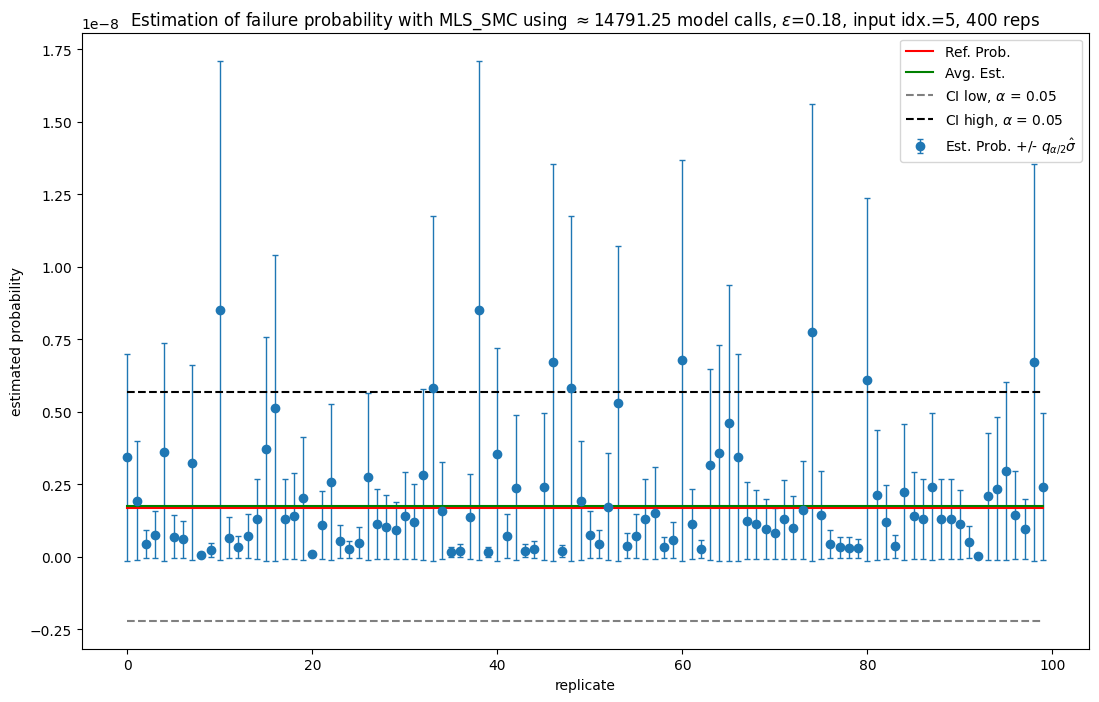

mean est:1.7433922039344908e-09, std est:2.0152643701244226e-09
mean calls:14791.25
std. re.:663043203.1448861
std. rel. adj.:9807237778516.797
mean rel. error:0.7938409280503417
std rel. error:0.8996529219626812
stat performance (per 1k calls):13.306991281980508
Starting MLS_SMC simulation 8/16, with model: model, img_idx:5,eps:0.18, N: 100: T: 20: ratio: 0.5: s: 1.0


100%|██████████| 400/400 [01:31<00:00,  4.38it/s]


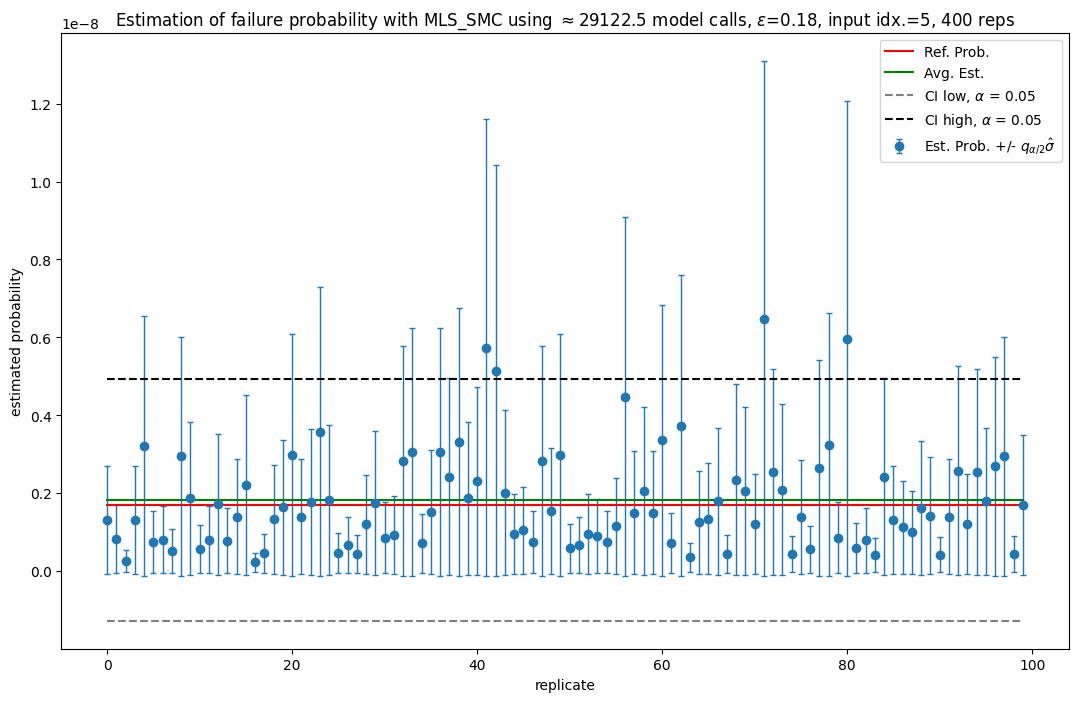

mean est:1.8292368622496726e-09, std est:1.5858493537513402e-09
mean calls:29122.5
std. re.:473938555.3507337
std. rel. adj.:13802275578201.742
mean rel. error:0.6472961722043307
std rel. error:0.6923952298632289
stat performance (per 1k calls):20.16428008169188
Starting MLS_SMC simulation 9/16, with model: model, img_idx:5,eps:0.18, N: 200: T: 2: ratio: 0.5: s: 1.0


100%|██████████| 400/400 [00:17<00:00, 23.42it/s]


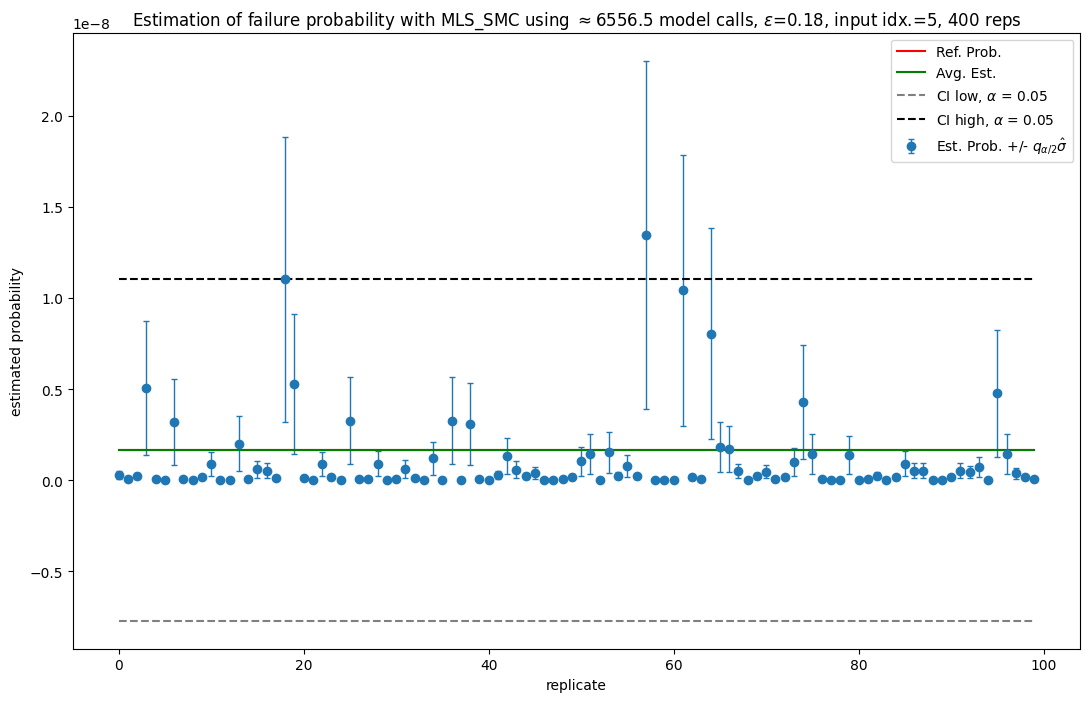

mean est:1.660842709583221e-09, std est:4.784199126752712e-09
mean calls:6556.5
std. re.:1734411875.7272837
std. rel. adj.:11371671463205.936
mean rel. error:1.3538932515723445
std rel. error:2.5044461598432273
stat performance (per 1k calls):16.42040124701212
Starting MLS_SMC simulation 10/16, with model: model, img_idx:5,eps:0.18, N: 200: T: 5: ratio: 0.5: s: 1.0


100%|██████████| 400/400 [00:38<00:00, 10.30it/s]


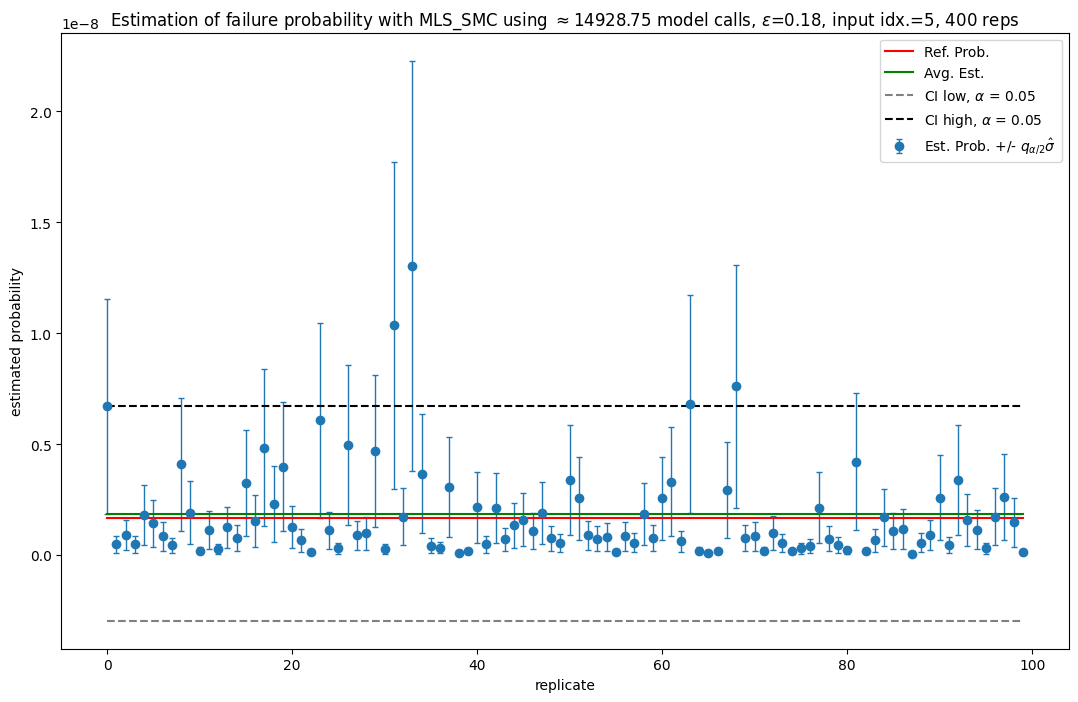

mean est:1.8710881704464553e-09, std est:2.4638179887050266e-09
mean calls:14928.75
std. re.:703752767.3936692
std. rel. adj.:10506149126228.24
mean rel. error:0.9175153071281766
std rel. error:1.1491917694519618
stat performance (per 1k calls):17.155996628205976
Starting MLS_SMC simulation 11/16, with model: model, img_idx:5,eps:0.18, N: 200: T: 10: ratio: 0.5: s: 1.0


100%|██████████| 400/400 [00:44<00:00,  9.01it/s]


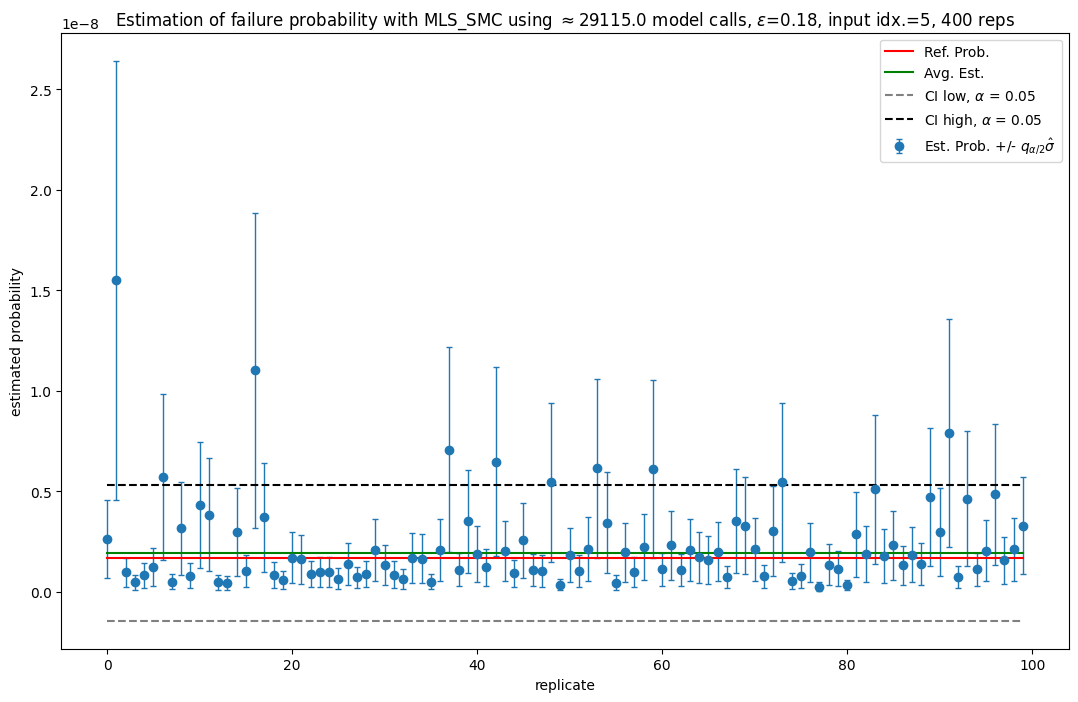

mean est:1.926961704157293e-09, std est:1.719858890159377e-09
mean calls:29115.0
std. re.:463176640.3486325
std. rel. adj.:13485387883750.436
mean rel. error:0.6763621456392173
std rel. error:0.7819765189008193
stat performance (per 1k calls):22.767246347797354
Starting MLS_SMC simulation 12/16, with model: model, img_idx:5,eps:0.18, N: 200: T: 20: ratio: 0.5: s: 1.0


100%|██████████| 400/400 [01:22<00:00,  4.82it/s]


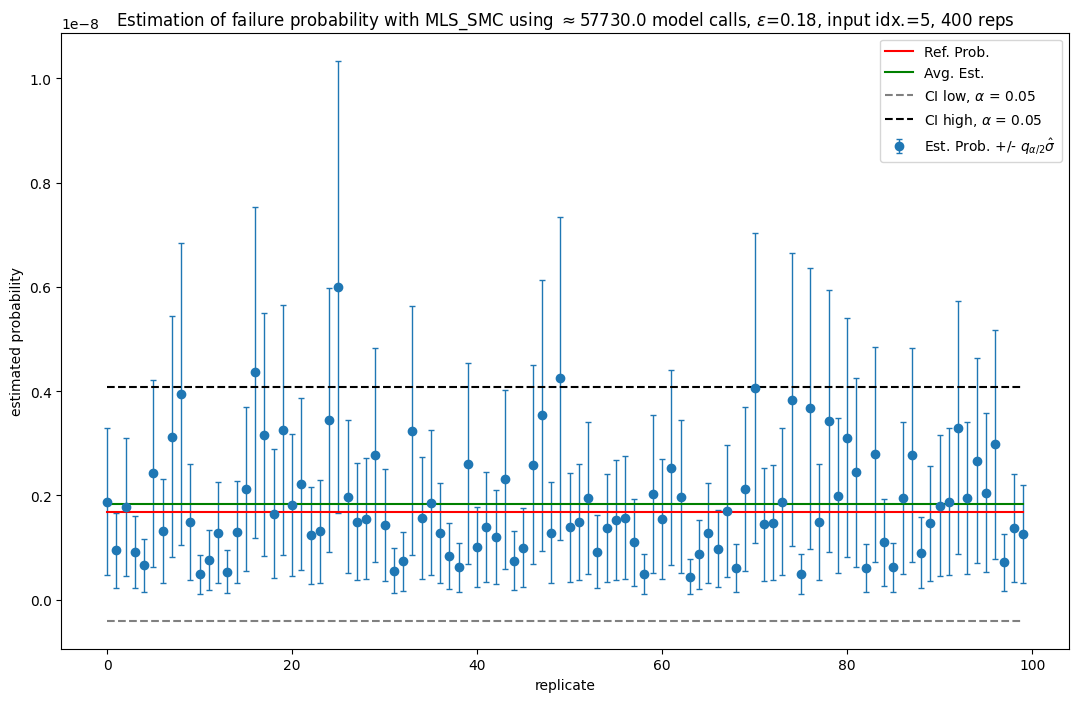

mean est:1.8365797586739063e-09, std est:1.142547859665647e-09
mean calls:57730.0
std. re.:338730898.3900451
std. rel. adj.:19554934764057.305
mean rel. error:0.4839294876382682
std rel. error:0.48652618141241394
stat performance (per 1k calls):28.087156452938654
Starting MLS_SMC simulation 13/16, with model: model, img_idx:5,eps:0.18, N: 500: T: 2: ratio: 0.5: s: 1.0


100%|██████████| 400/400 [00:11<00:00, 33.71it/s]


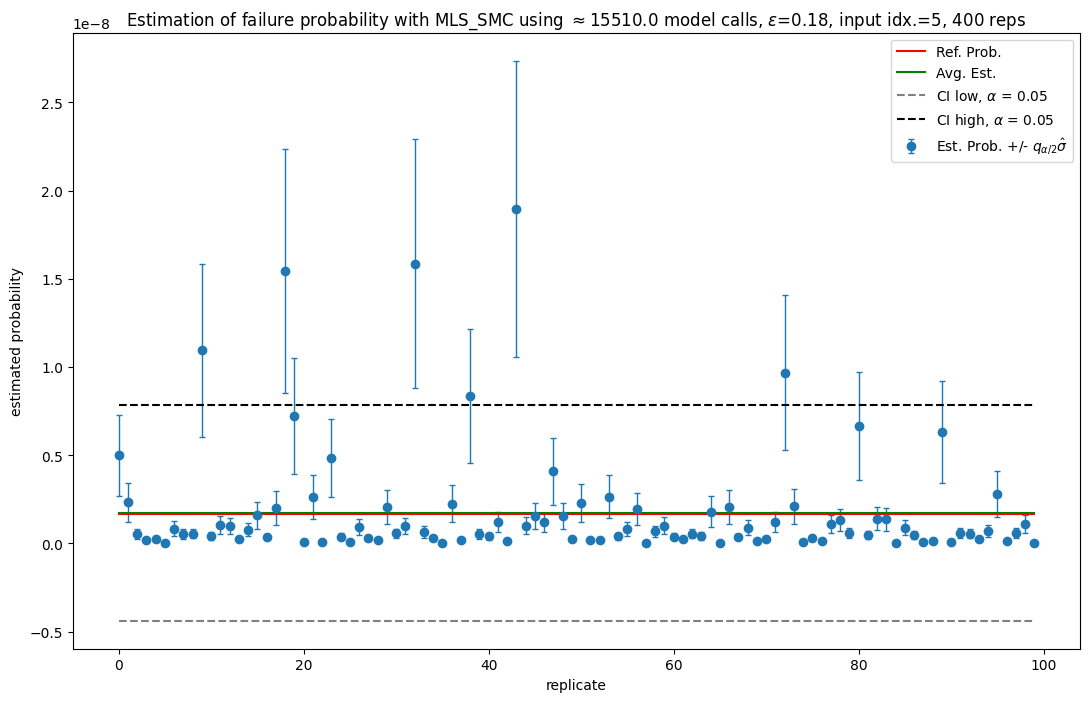

mean est:1.7399941134499385e-09, std est:3.1213245079793845e-09
mean calls:15510.0
std. re.:1030963676.6530597
std. rel. adj.:15990246624888.957
mean rel. error:1.061178568228169
std rel. error:1.5248480818847117
stat performance (per 1k calls):23.650393750031878
Starting MLS_SMC simulation 14/16, with model: model, img_idx:5,eps:0.18, N: 500: T: 5: ratio: 0.5: s: 1.0


100%|██████████| 400/400 [00:25<00:00, 15.87it/s]


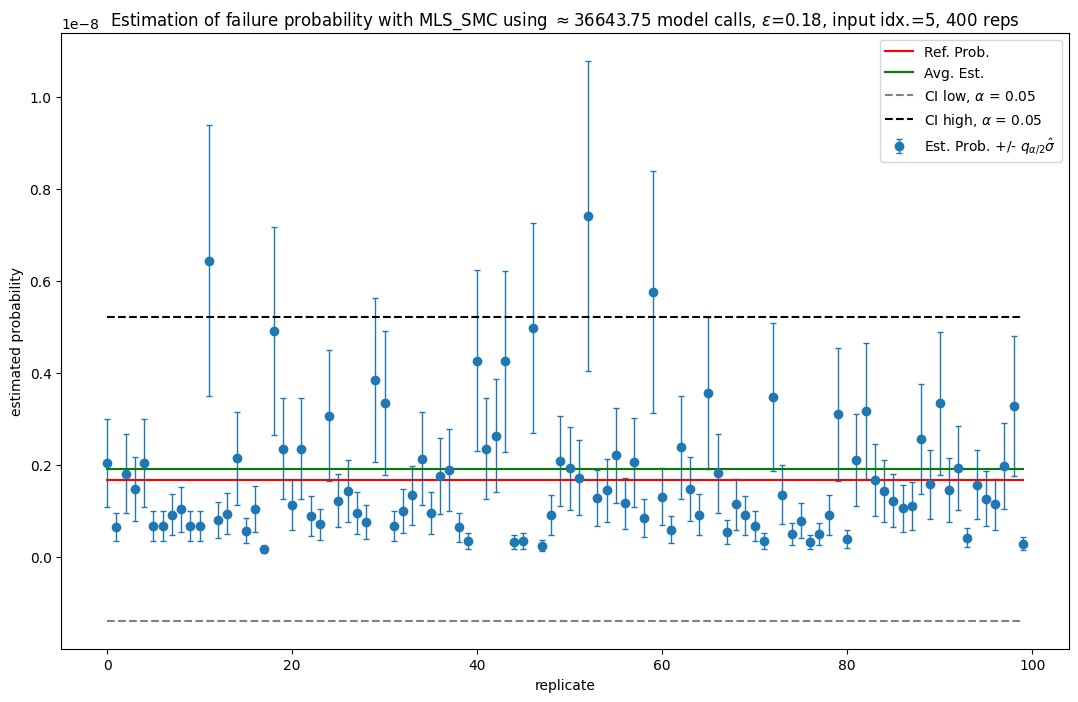

mean est:1.918624620884657e-09, std est:1.6857646939944217e-09
mean calls:36643.75
std. re.:457948802.1011707
std. rel. adj.:16780961416994.775
mean rel. error:0.6604570146092379
std rel. error:0.7682460039098662
stat performance (per 1k calls):28.151414505772156
Starting MLS_SMC simulation 15/16, with model: model, img_idx:5,eps:0.18, N: 500: T: 10: ratio: 0.5: s: 1.0


100%|██████████| 400/400 [00:43<00:00,  9.30it/s]


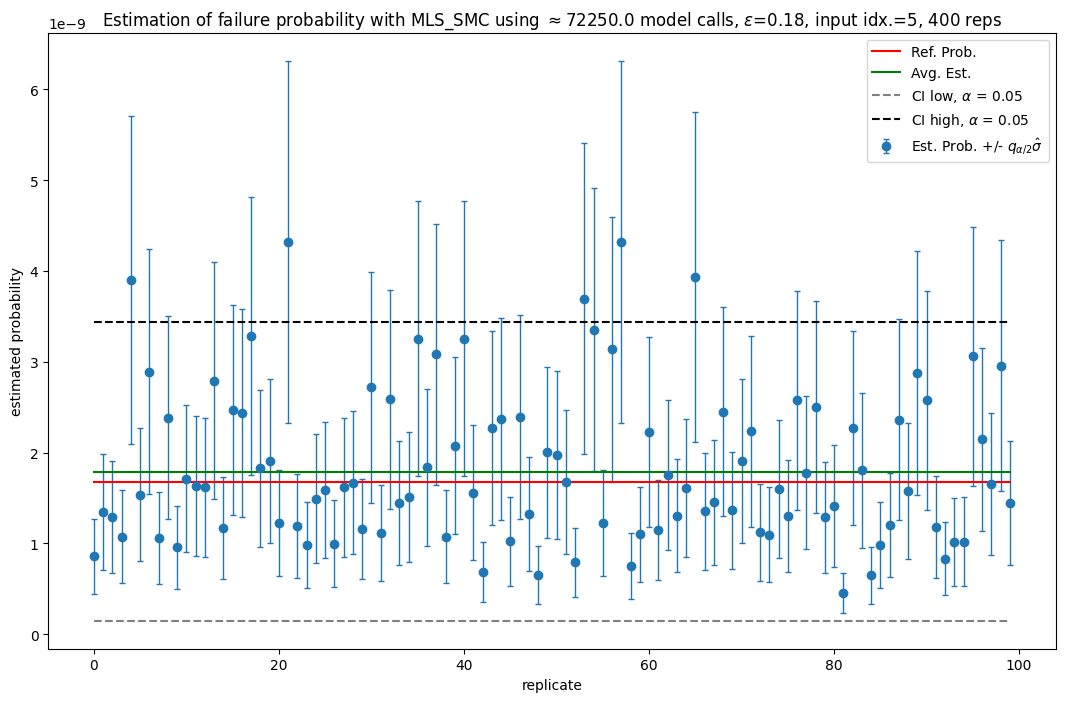

mean est:1.7920811660587788e-09, std est:8.381972857170237e-10
mean calls:72250.0
std. re.:260994225.63763127
std. rel. adj.:18856832802318.86
mean rel. error:0.38740639683167283
std rel. error:0.3211214719878132
stat performance (per 1k calls):23.201026351119506
Starting MLS_SMC simulation 16/16, with model: model, img_idx:5,eps:0.18, N: 500: T: 20: ratio: 0.5: s: 1.0


100%|██████████| 400/400 [01:20<00:00,  5.00it/s]


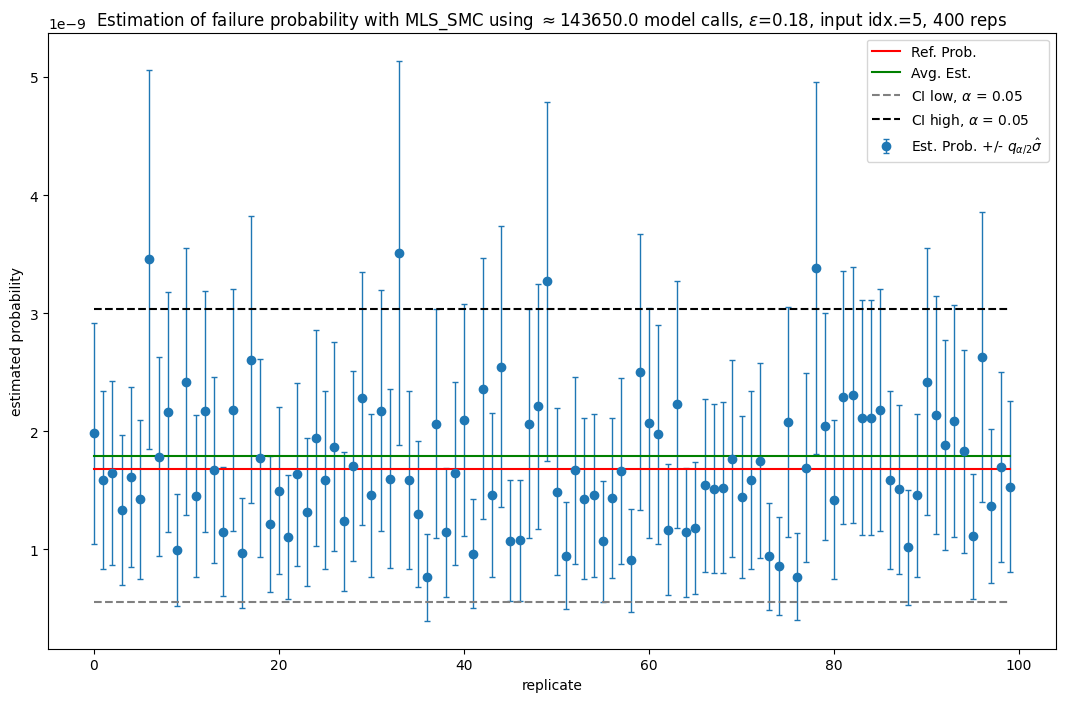

mean est:1.7947517335414885e-09, std est:6.318676935476673e-10
mean calls:143650.0
std. re.:196163132.521931
std. rel. adj.:28178833986775.387
mean rel. error:0.28152978221820385
std rel. error:0.25835724451827213
stat performance (per 1k calls):37.113018175049795
p_fail_mls: 1.8053604644143513e-09


In [100]:
N_range_low = [50,100,200,500]
N_range_high = [1000,2000,5000,10000]
N_range = N_range_low + N_range_high
T_range_low= [2,5,10,20]
T_range_high = [50,100,200,500]
T_range = T_range_low + T_range_high
p_fail_mls,dict_out=run_exp.run_est(model=model,method='amls_batch',X=exp_config.X,y=exp_config.y,dataset_name=dataset,
                        epsilon_range=epsilon_range, n_rep=400, update_aggr_res=True, 
                        input_start=input_index,input_stop=input_index+1,
                         N_range=N_range_low,T_range=T_range_low,ratio_range=[0.5,],repeat_exp=False,
                        verbose=0,np_seed=0, torch_seed=0,p_ref = p_ref)
exp_config,method_config_mls, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_df_mls = dict_out['results_df']
print(f"p_fail_mls: {p_fail_mls}")

Files already downloaded and verified
with parameters in {'N_range': [10000], 'batch_size_range': [2000]}
Starting IS simulation 1/1, with model: model, img_idx:5,eps:0.18, N: 10000: batch_size: 2000


  1%|▏         | 5/400 [00:00<00:08, 48.14it/s]

  3%|▎         | 12/400 [00:00<00:07, 55.29it/s]

  4%|▍         | 18/400 [00:00<00:07, 54.53it/s]

  8%|▊         | 30/400 [00:00<00:07, 52.65it/s]

 10%|█         | 41/400 [00:00<00:07, 46.36it/s]

 13%|█▎        | 52/400 [00:01<00:07, 49.12it/s]

 14%|█▍        | 58/400 [00:01<00:07, 47.55it/s]

 16%|█▌        | 63/400 [00:01<00:07, 47.77it/s]

 17%|█▋        | 68/400 [00:01<00:07, 44.75it/s]

 20%|██        | 80/400 [00:01<00:06, 49.22it/s]

 23%|██▎       | 91/400 [00:01<00:06, 50.75it/s]

 26%|██▌       | 103/400 [00:02<00:05, 52.19it/s]

 29%|██▉       | 115/400 [00:02<00:05, 53.98it/s]

 30%|███       | 121/400 [00:02<00:05, 52.56it/s]

 32%|███▏      | 127/400 [00:02<00:05, 50.95it/s]

 33%|███▎      | 133/400 [00:02<00:05, 52.79it/s]

 35%|███▍      | 139/400 [00:02<00:04, 54.39it/s]

 36%|███▋      | 145/400 [00:02<00:04, 55.94it/s]

 39%|███▉      | 157/400 [00:03<00:04, 51.25it/s]

 42%|████▏     | 169/400 [00:03<00:04, 50.06it/s]

 44%|████▍     | 175/400 [00:03<00:04, 50.12it/s]

 47%|████▋     | 187/400 [00:03<00:04, 49.11it/s]

 50%|████▉     | 198/400 [00:03<00:04, 49.63it/s]

 52%|█████▎    | 210/400 [00:04<00:03, 51.23it/s]

 56%|█████▌    | 222/400 [00:04<00:03, 49.45it/s]

 57%|█████▋    | 227/400 [00:04<00:03, 49.13it/s]

 61%|██████    | 243/400 [00:04<00:03, 49.16it/s]

 64%|██████▍   | 255/400 [00:05<00:02, 53.41it/s]

 65%|██████▌   | 261/400 [00:05<00:02, 54.17it/s]

 68%|██████▊   | 273/400 [00:05<00:02, 51.16it/s]

 71%|███████   | 284/400 [00:05<00:02, 49.36it/s]

 74%|███████▎  | 294/400 [00:05<00:02, 48.93it/s]

 76%|███████▋  | 306/400 [00:06<00:01, 49.25it/s]

 79%|███████▉  | 316/400 [00:06<00:01, 49.36it/s]

 82%|████████▏ | 326/400 [00:06<00:01, 48.27it/s]

 84%|████████▍ | 337/400 [00:06<00:01, 49.09it/s]

 87%|████████▋ | 347/400 [00:06<00:01, 48.24it/s]

 89%|████████▉ | 357/400 [00:07<00:00, 47.38it/s]

 92%|█████████▏| 367/400 [00:07<00:00, 47.57it/s]

 94%|█████████▍| 378/400 [00:07<00:00, 49.21it/s]

 97%|█████████▋| 388/400 [00:07<00:00, 48.41it/s]

100%|█████████▉| 398/400 [00:07<00:00, 48.19it/s]

100%|██████████| 400/400 [00:08<00:00, 49.83it/s]


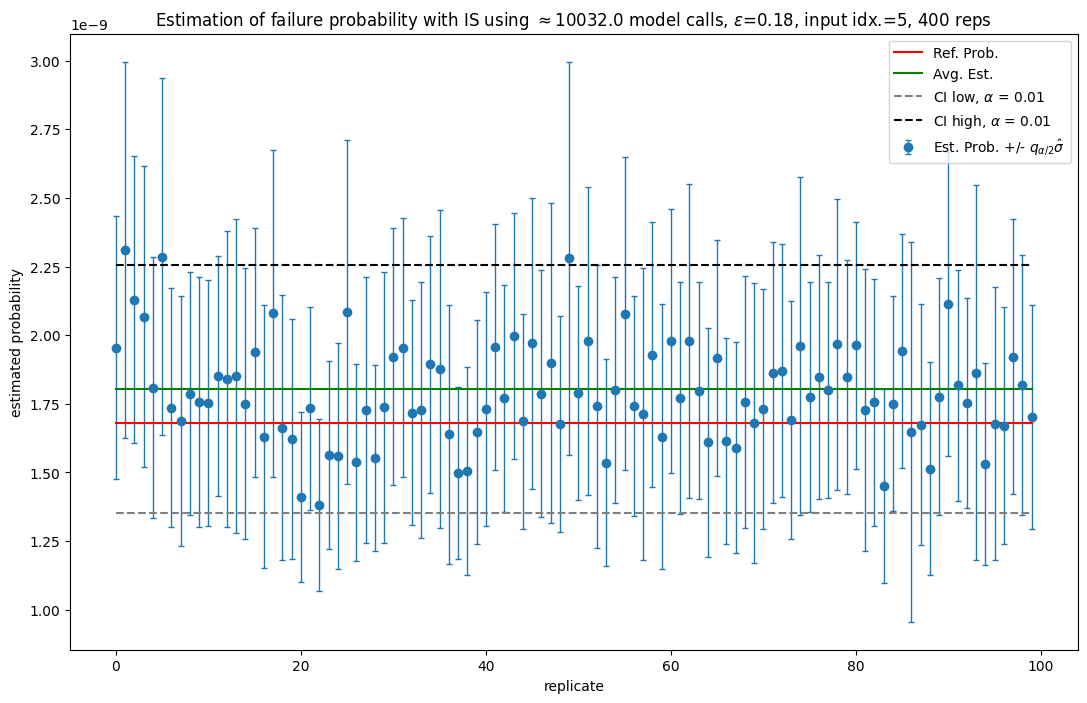

mean est:1.8040366978056e-09, std est:1.7536334884216132e-10
mean calls:10032.0
std. re.:53882544.33807251
std. rel. adj.:540549684799.5434
mean rel. error:0.10113108903169632
std rel. error:0.0779087170958519
stat performance (per 1k calls):0.7815802499055863


KeyError: 'weights_list'

In [96]:
N_range_high=[5000,10000,20000,50000,10000]
N_range_low = [100,200,500,1000,2000,]

p_fail_mls,dict_out=run_exp.run_est(model=model,method='is',X=config.X,y=config.y,dataset_name=dataset, p_ref=p_ref,
                                    input_start=input_index,input_stop=input_index+1,
                                
                        epsilon_range=epsilon_range, n_rep=400, update_aggr_res=True, save_weights=False,
                         N_range=[10000],batch_size_range=[2000],repeat_exp=True,alpha_CI=0.01,
                        verbose=0,np_seed=0, torch_seed=0,sigma_bias=1.)
exp_config,method_config_mls, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_df_mls = dict_out['results_df']
weights_list = dict_out['weights_list']
print(f"p_fail_mls: {p_fail_mls}")

(array([9.637e+03, 1.000e+02, 7.100e+01, 4.300e+01, 3.700e+01, 2.500e+01,
        1.200e+01, 1.400e+01, 1.200e+01, 9.000e+00, 7.000e+00, 5.000e+00,
        5.000e+00, 1.000e+00, 5.000e+00, 4.000e+00, 3.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([0.        , 0.00052045, 0.00104089, 0.00156134, 0.00208179,
        0.00260224, 0.00312268, 0.00364313, 0.00416358, 0.00468402,
        0.00520447, 0.00572492, 0.00624537, 0.00676581, 0.00728626,
        0.00780671, 0.00832715, 0.0088476 , 0.00936805, 0.0098885 ,
        0.01040894, 0.01092939, 0.01144984, 0.01197028, 0.01249073,
        0.01301118, 0.01353163, 0.01405207, 0.01457252, 0.01509297,
        0.01561341, 0.01613386, 0.01665431, 0.01717476, 0.0176952 ,
        0.01821565, 0.0187

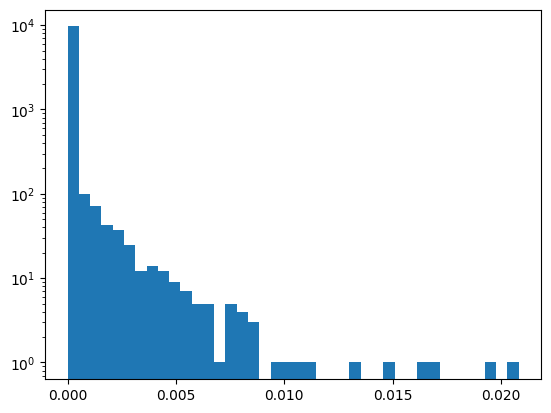

In [39]:
weights0=weights_list[0]
normalized_weights=weights0/weights0.sum()
#plot histgram of the weights with log scale between 1e-5 and 1e-1
plt.hist(normalized_weights,bins=40,log=True)

In [36]:
weights_list

[array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        5.0462313e-06, 0.0000000e+00], dtype=float32),
 array([0.0000000e+00, 4.1689436e-06, 3.9775614e-07, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 

with parameters in {'N_range': [100, 100, 10000], 'T_range': [2, 5, 10, 20], 'ratio_range': [0.2, 0.5, 0.8], 's_range': [1.0]}
Experiment already done for method: MLS_SMC
Starting MLS_SMC simulation 1/36, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [00:03<00:00, 110.30it/s]


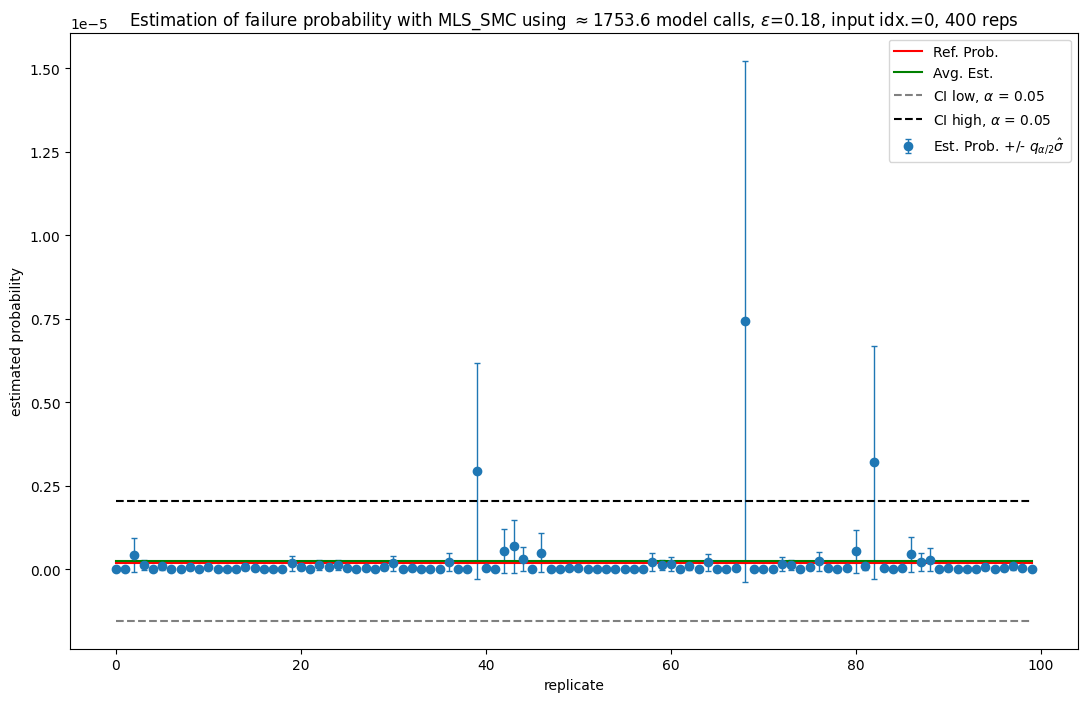

mean est:2.5447429269094413e-07, std est:9.130619251906983e-07
mean calls:1753.6
std. re.:14099782.103787187
std. rel. adj.:24725377897.20121
mean rel. error:1.5945627399173044
std rel. error:4.419012451802254
stat performance (per 1k calls):7.7491802354804316
Experiment already done for method: MLS_SMC
Skipping MLS_SMC run 2/36, with model: mnist_model, img_idx:0,eps:0.18,N: 100: T: 2: ratio: 0.5: s: 1.0
Experiment already done for method: MLS_SMC
Starting MLS_SMC simulation 3/36, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [00:23<00:00, 17.28it/s]


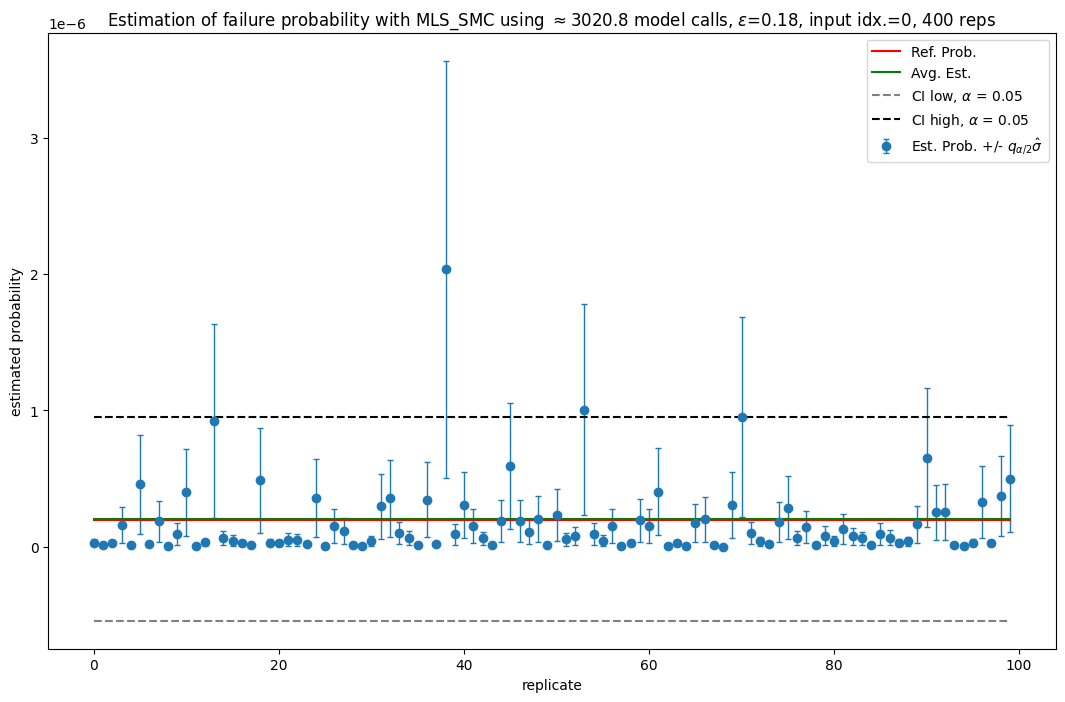

mean est:2.030089310665433e-07, std est:3.806595363073075e-07
mean calls:3020.8
std. re.:9236478.535736648
std. rel. adj.:27901554360.75327
mean rel. error:0.9982970764717206
std rel. error:1.6807389906467884
stat performance (per 1k calls):5.077176342945819
Experiment already done for method: MLS_SMC
Starting MLS_SMC simulation 4/36, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [00:06<00:00, 58.53it/s]


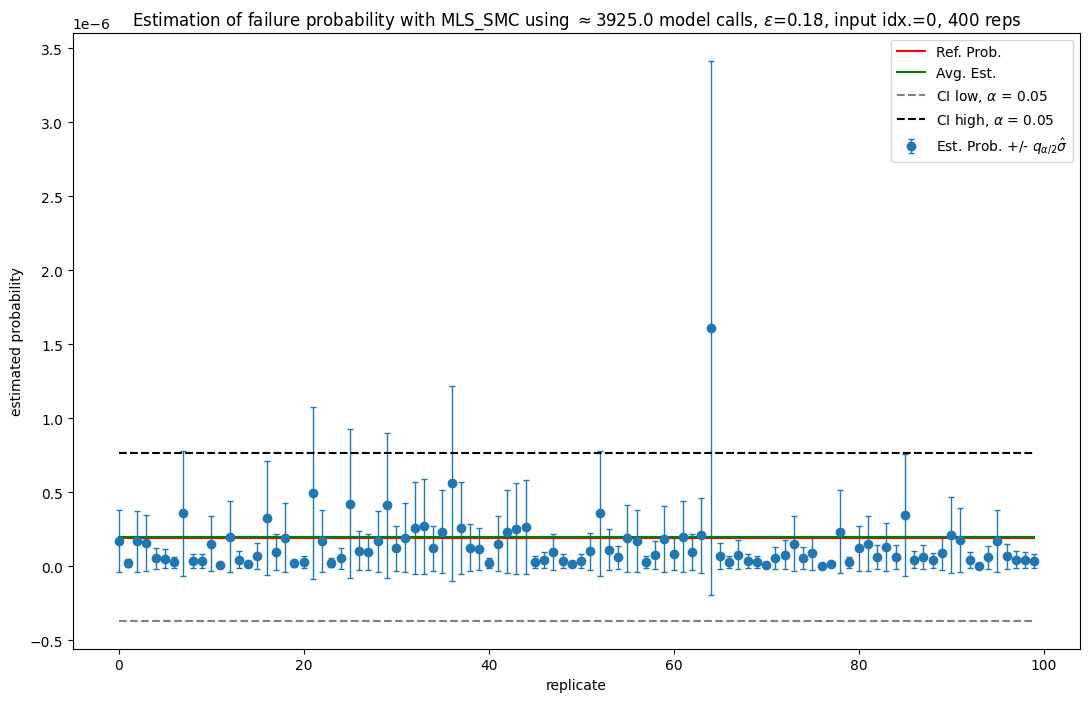

mean est:1.989755904000001e-07, std est:2.8851231379920513e-07
mean calls:3925.0
std. re.:7287268.13511654
std. rel. adj.:28602527430.33242
mean rel. error:0.9049656185190745
std rel. error:1.172919647827694
stat performance (per 1k calls):4.603709617723698
Experiment already done for method: MLS_SMC
Skipping MLS_SMC run 5/36, with model: mnist_model, img_idx:0,eps:0.18,N: 100: T: 5: ratio: 0.5: s: 1.0
Experiment already done for method: MLS_SMC
Starting MLS_SMC simulation 6/36, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [00:47<00:00,  8.44it/s]


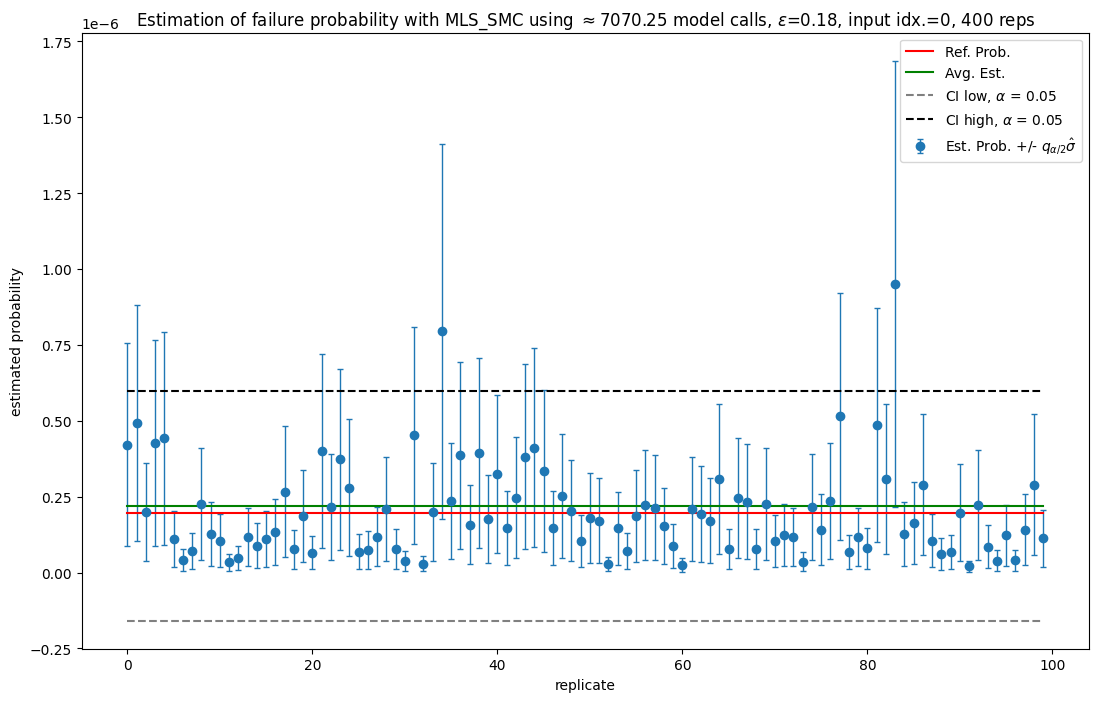

mean est:2.2047144103928907e-07, std est:1.934614938901134e-07
mean calls:7070.25
std. re.:3980062.1663511163
std. rel. adj.:28140034531.64398
mean rel. error:0.6768347590548217
std rel. error:0.7388596741125915
stat performance (per 1k calls):5.223922610894549
Experiment already done for method: MLS_SMC
Starting MLS_SMC simulation 7/36, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [00:12<00:00, 32.06it/s]


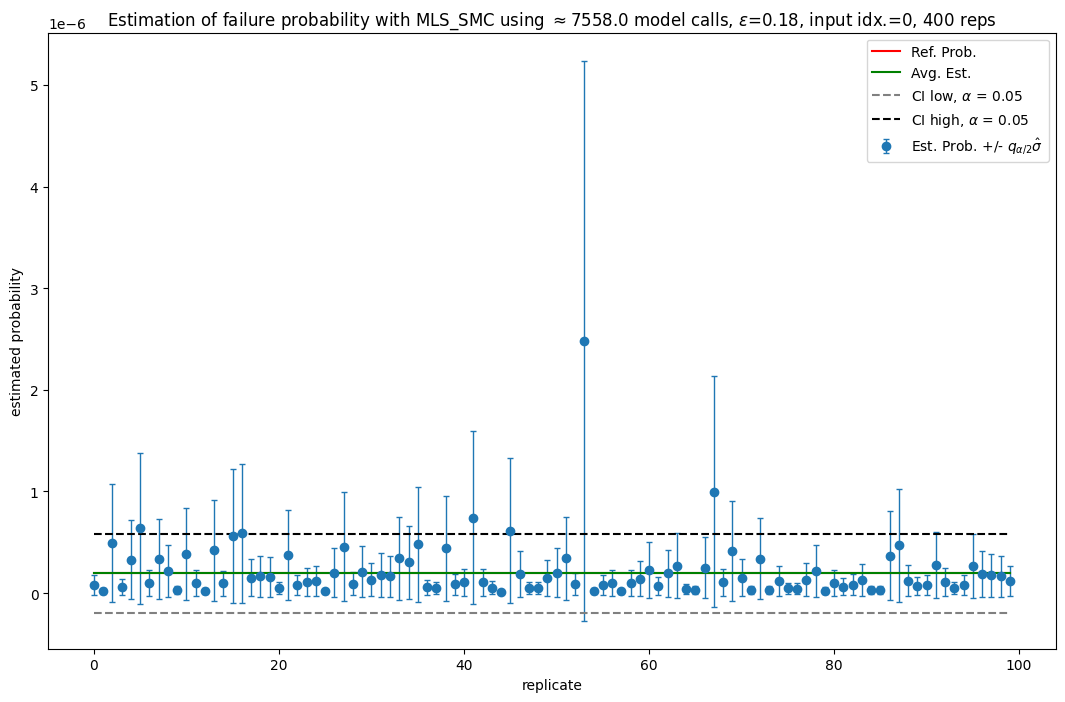

mean est:1.9587737600000007e-07, std est:1.9896309938591392e-07
mean calls:7558.0
std. re.:5185659.330397955
std. rel. adj.:39193213219.14774
mean rel. error:0.6313136119643885
std rel. error:0.803114793544009
stat performance (per 1k calls):6.06994160960562
Experiment already done for method: MLS_SMC
Skipping MLS_SMC run 8/36, with model: mnist_model, img_idx:0,eps:0.18,N: 100: T: 10: ratio: 0.5: s: 1.0
Experiment already done for method: MLS_SMC
Starting MLS_SMC simulation 9/36, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [01:27<00:00,  4.58it/s]


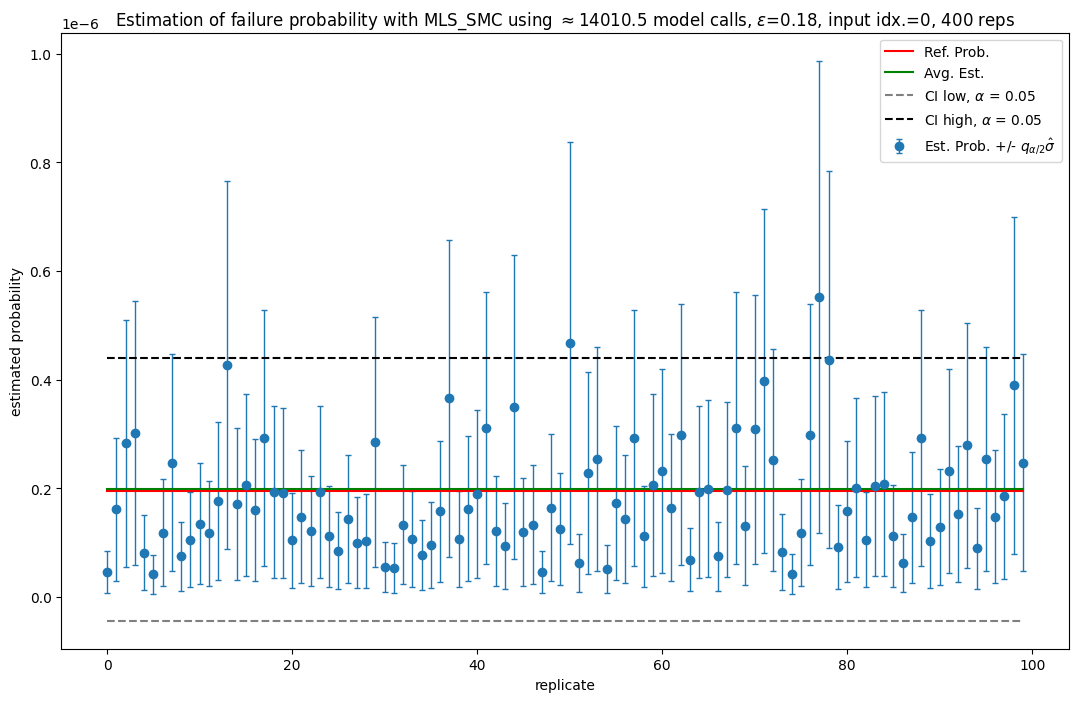

mean est:1.980917854243897e-07, std est:1.2330792795735818e-07
mean calls:14010.5
std. re.:3142375.4075376876
std. rel. adj.:44026250647.30677
mean rel. error:0.4850195461083376
std rel. error:0.40725335476123237
stat performance (per 1k calls):5.705823126882247
Experiment already done for method: MLS_SMC
Starting MLS_SMC simulation 10/36, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [00:23<00:00, 17.05it/s]


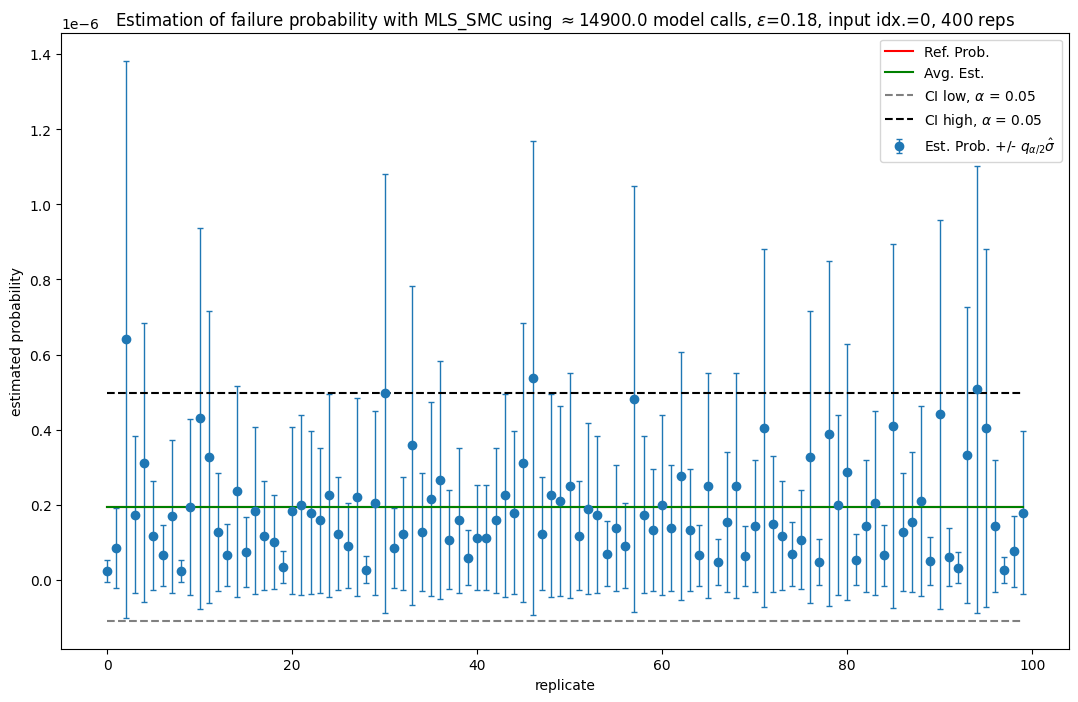

mean est:1.9379353600000009e-07, std est:1.5431844385354047e-07
mean calls:14900.0
std. re.:4109029.5186665524
std. rel. adj.:61224539828.13163
mean rel. error:0.525062611270226
std rel. error:0.593371621928221
stat performance (per 1k calls):8.841237166730494
Experiment already done for method: MLS_SMC
Skipping MLS_SMC run 11/36, with model: mnist_model, img_idx:0,eps:0.18,N: 100: T: 20: ratio: 0.5: s: 1.0
Experiment already done for method: MLS_SMC
Starting MLS_SMC simulation 12/36, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [02:45<00:00,  2.41it/s]


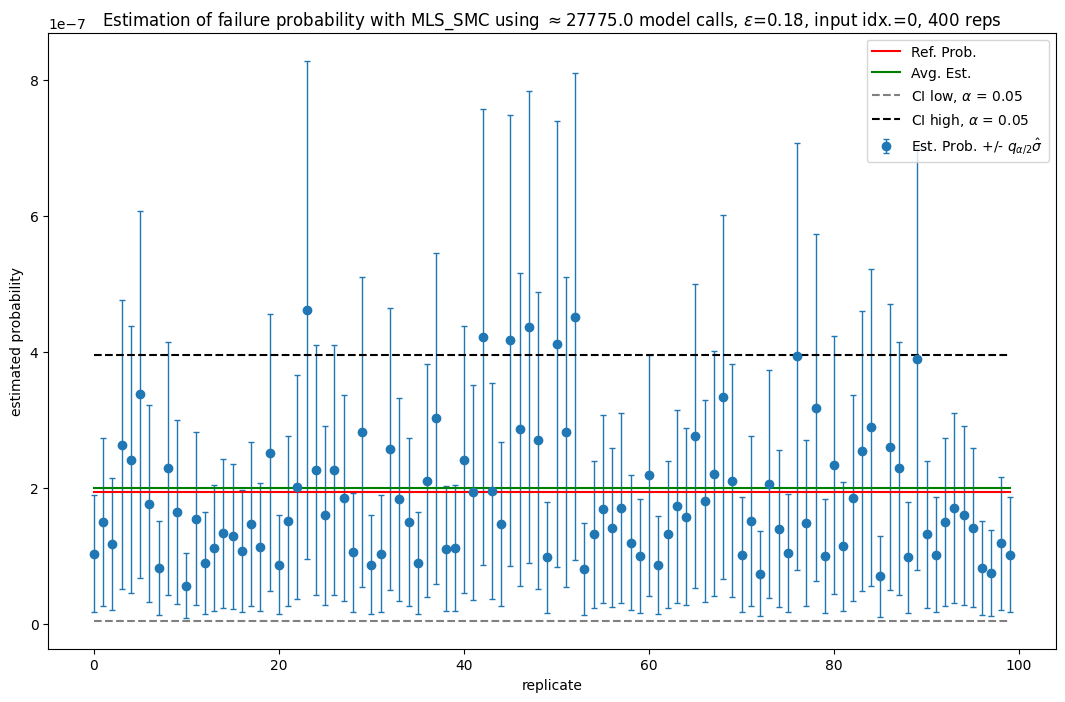

mean est:2.004998278246306e-07, std est:9.981649596328191e-08
mean calls:27775.0
std. re.:2482986.23501959
std. rel. adj.:68964942677.66911
mean rel. error:0.3995672445535278
std rel. error:0.32225851548204204
stat performance (per 1k calls):8.950730267513718
Experiment already done for method: MLS_SMC
Skipping MLS_SMC run 13/36, with model: mnist_model, img_idx:0,eps:0.18,N: 100: T: 2: ratio: 0.2: s: 1.0
Experiment already done for method: MLS_SMC
Skipping MLS_SMC run 14/36, with model: mnist_model, img_idx:0,eps:0.18,N: 100: T: 2: ratio: 0.5: s: 1.0
Experiment already done for method: MLS_SMC
Skipping MLS_SMC run 15/36, with model: mnist_model, img_idx:0,eps:0.18,N: 100: T: 2: ratio: 0.8: s: 1.0
Experiment already done for method: MLS_SMC
Skipping MLS_SMC run 16/36, with model: mnist_model, img_idx:0,eps:0.18,N: 100: T: 5: ratio: 0.2: s: 1.0
Experiment already done for method: MLS_SMC
Skipping MLS_SMC run 17/36, with model: mnist_model, img_idx:0,eps:0.18,N: 100: T: 5: ratio: 0.5: s:

100%|██████████| 400/400 [00:28<00:00, 14.14it/s]


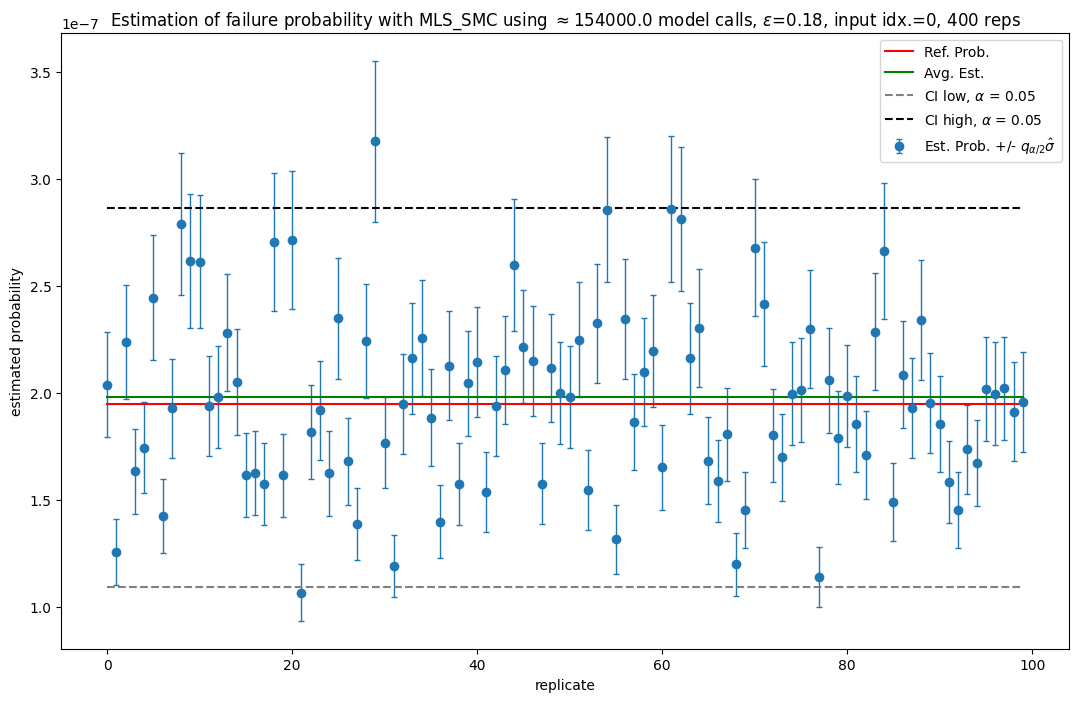

mean est:1.979388160000001e-07, std est:4.514393593140662e-08
mean calls:154000.0
std. re.:1152225.505896107
std. rel. adj.:177442727908.0005
mean rel. error:0.18283861904944043
std rel. error:0.14337672351169609
stat performance (per 1k calls):22.080015420801196
Experiment already done for method: MLS_SMC
Skipping MLS_SMC run 26/36, with model: mnist_model, img_idx:0,eps:0.18,N: 10000: T: 2: ratio: 0.5: s: 1.0
Experiment already done for method: MLS_SMC
Starting MLS_SMC simulation 27/36, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [00:45<00:00,  8.89it/s]


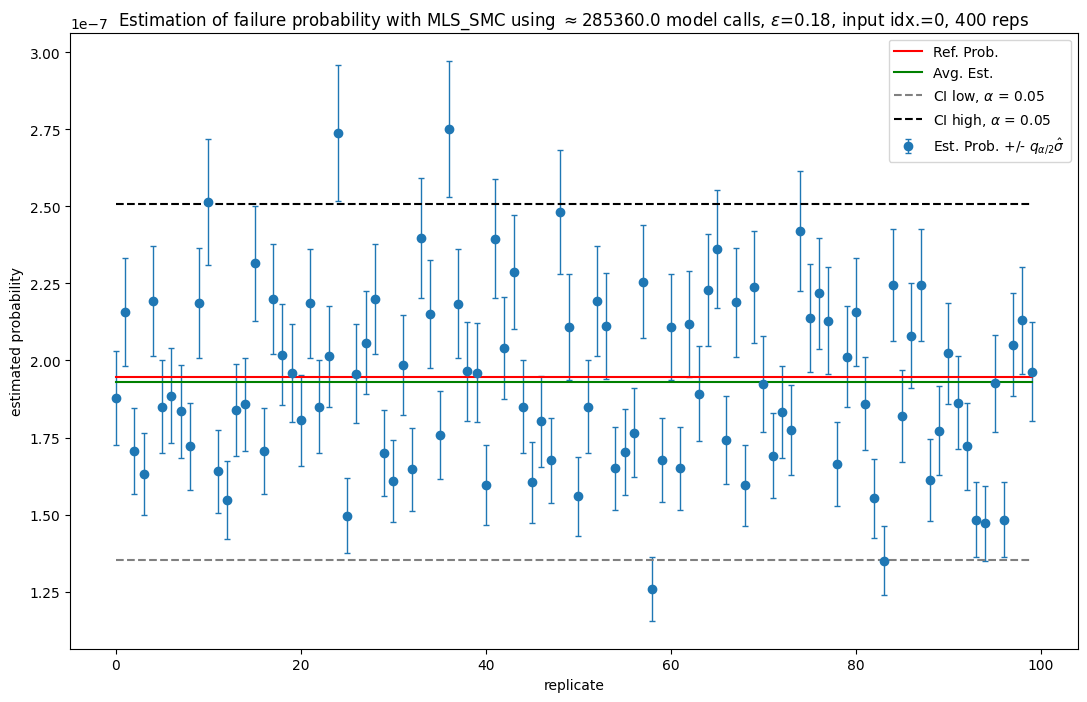

mean est:1.9296330707591091e-07, std est:2.9496031735126003e-08
mean calls:285360.0
std. re.:792162.2173306997
std. rel. adj.:226051410337.48846
mean rel. error:0.12354614923508278
std rel. error:0.08807117982527976
stat performance (per 1k calls):25.131991874941832
Experiment already done for method: MLS_SMC
Starting MLS_SMC simulation 28/36, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [01:02<00:00,  6.38it/s]


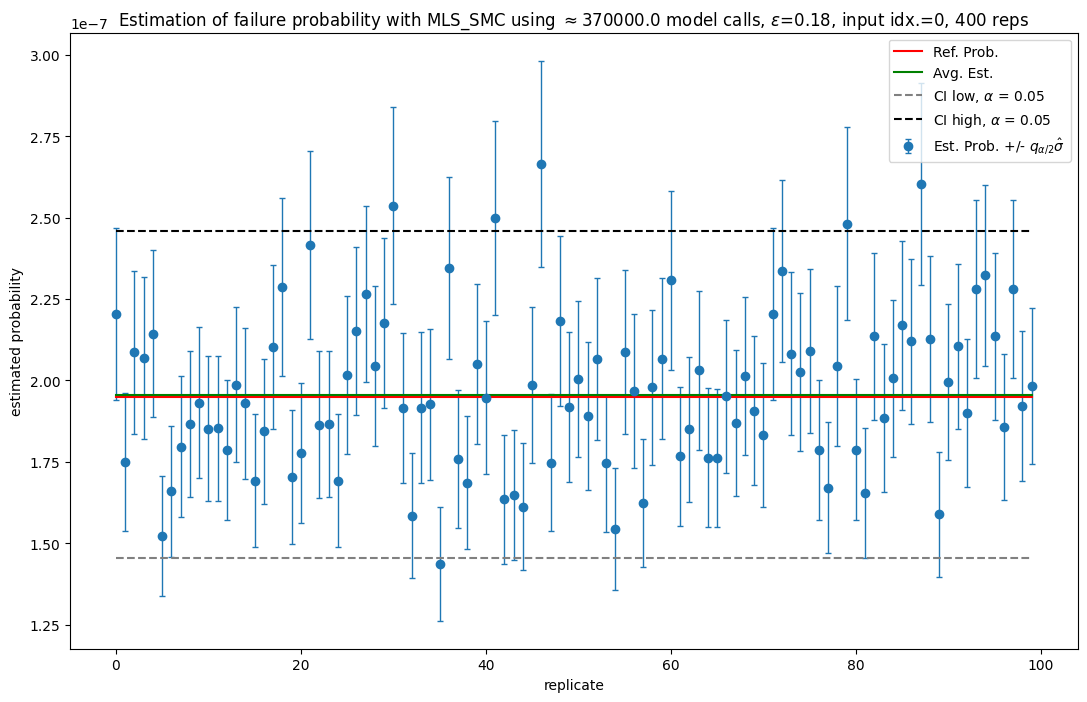

mean est:1.956034560000001e-07, std est:2.5601730276246266e-08
mean calls:370000.0
std. re.:669138.8878706456
std. rel. adj.:247581388512.1389
mean rel. error:0.1042850428023852
std rel. error:0.08013071454716611
stat performance (per 1k calls):29.64836438245146
Experiment already done for method: MLS_SMC
Skipping MLS_SMC run 29/36, with model: mnist_model, img_idx:0,eps:0.18,N: 10000: T: 5: ratio: 0.5: s: 1.0
Experiment already done for method: MLS_SMC
Starting MLS_SMC simulation 30/36, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [01:21<00:00,  4.89it/s]


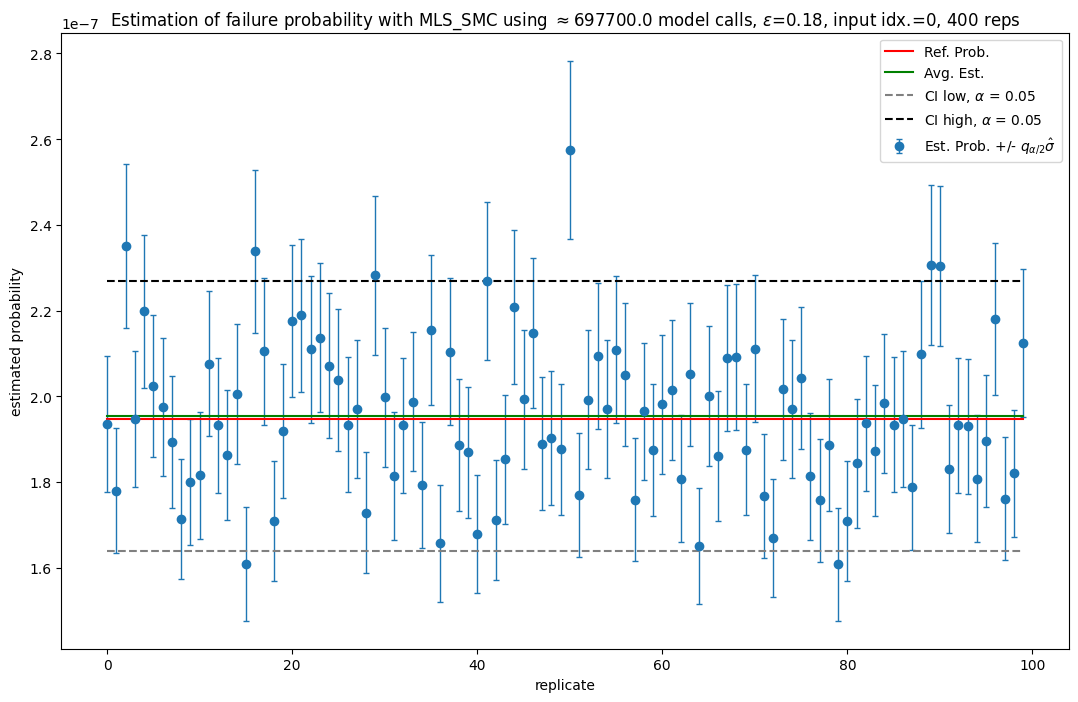

mean est:1.9546001442857874e-07, std est:1.604172842623676e-08
mean calls:697700.0
std. re.:419889.78256965044
std. rel. adj.:292957101298.8451
mean rel. error:0.06407776132248787
std rel. error:0.05186651109623795
stat performance (per 1k calls):36.18726479184522
Experiment already done for method: MLS_SMC
Starting MLS_SMC simulation 31/36, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [01:59<00:00,  3.35it/s]


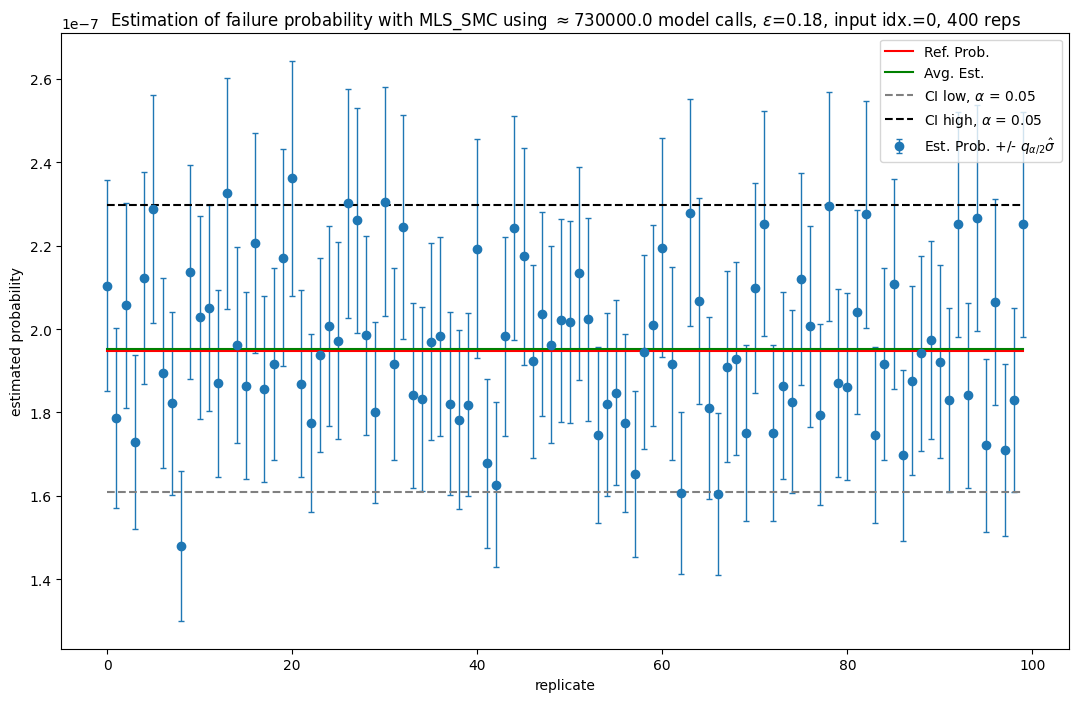

mean est:1.952828160000001e-07, std est:1.7584000170511382e-08
mean calls:730000.0
std. re.:461094.1595181243
std. rel. adj.:336598736448.2307
mean rel. error:0.07208558529043715
std rel. error:0.054416965475629
stat performance (per 1k calls):39.72438479720917
Experiment already done for method: MLS_SMC
Skipping MLS_SMC run 32/36, with model: mnist_model, img_idx:0,eps:0.18,N: 10000: T: 10: ratio: 0.5: s: 1.0
Experiment already done for method: MLS_SMC
Starting MLS_SMC simulation 33/36, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [02:22<00:00,  2.80it/s]


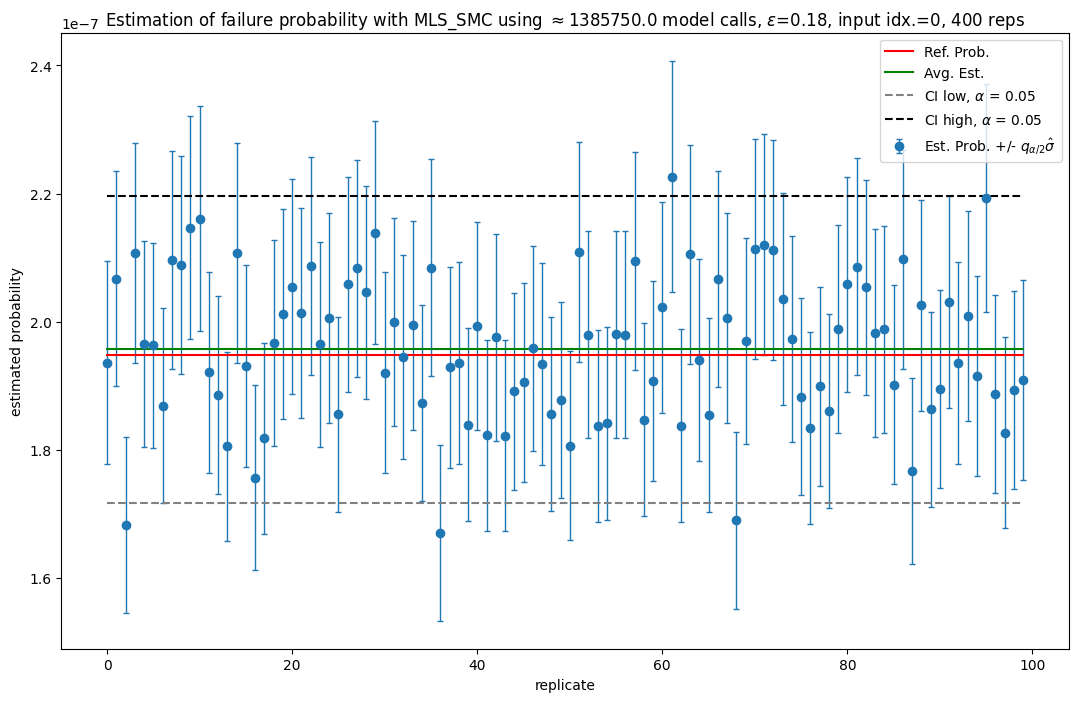

mean est:1.9570929294240766e-07, std est:1.2232515776016742e-08
mean calls:1385750.0
std. re.:319369.09577236534
std. rel. adj.:442565724466.5553
mean rel. error:0.05082101551076172
std rel. error:0.03721450987501363
stat performance (per 1k calls):51.57000705930014
Experiment already done for method: MLS_SMC
Starting MLS_SMC simulation 34/36, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [03:53<00:00,  1.72it/s]


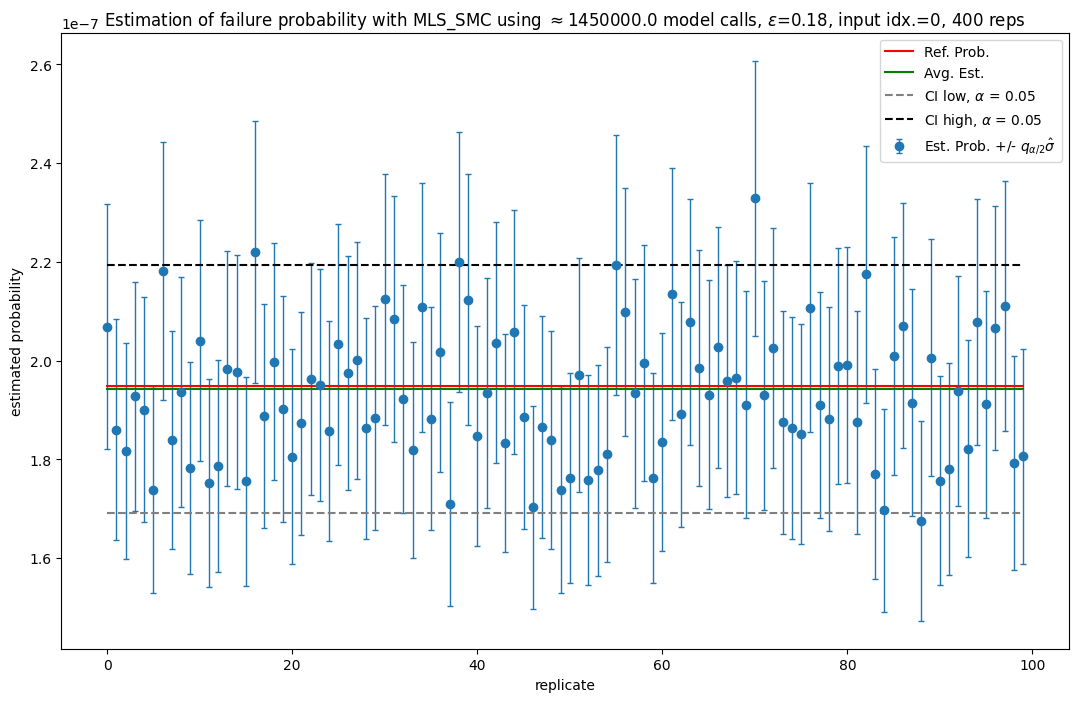

mean est:1.9425139200000008e-07, std est:1.2787616588369242e-08
mean calls:1450000.0
std. re.:338892.0079737974
std. rel. adj.:491393411562.0062
mean rel. error:0.053466509459281275
std rel. error:0.03819675438588315
stat performance (per 1k calls):55.38529385953057
Experiment already done for method: MLS_SMC
Skipping MLS_SMC run 35/36, with model: mnist_model, img_idx:0,eps:0.18,N: 10000: T: 20: ratio: 0.5: s: 1.0
Experiment already done for method: MLS_SMC
Starting MLS_SMC simulation 36/36, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 400/400 [04:23<00:00,  1.52it/s]


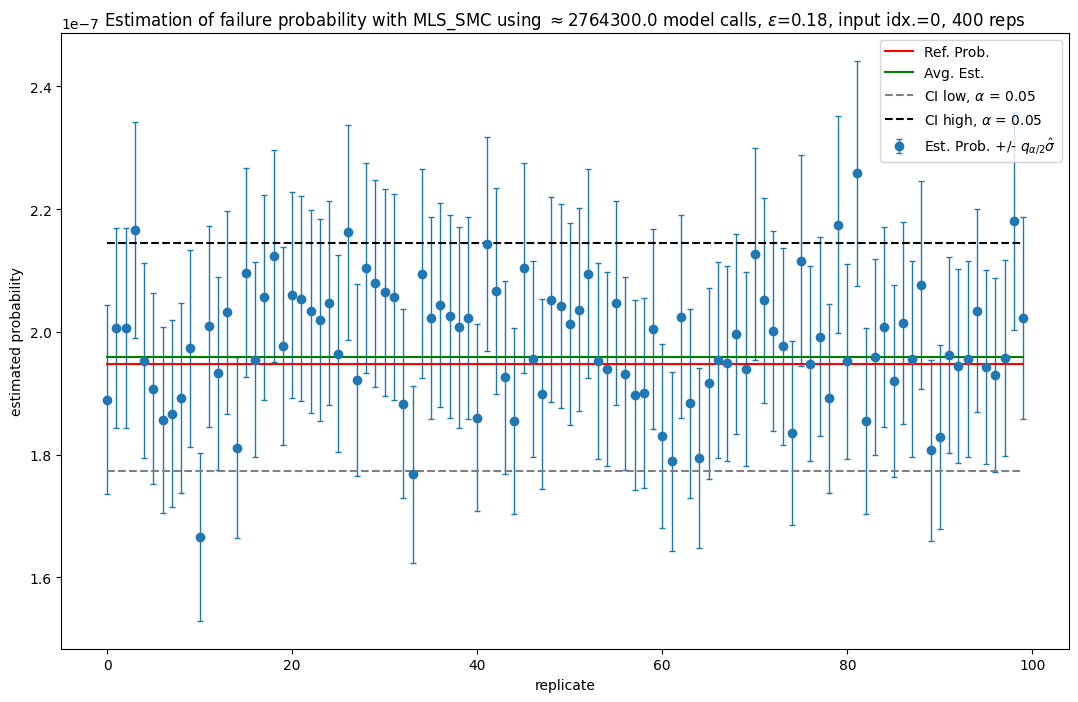

mean est:1.9588075965948228e-07, std est:9.473357237264925e-09
mean calls:2764300.0
std. re.:246899.582459781
std. rel. adj.:682504515793.5726
mean rel. error:0.03863108353541863
std rel. error:0.030097600714562123
stat performance (per 1k calls):83.19879765526409
p_fail_mls: 2.0176766465951106e-07


In [18]:
p_fail_mls,dict_out=run_exp.run_est(model=model,method='amls_batch',X=X,y=y,dataset_name=dataset,
                        epsilon_range=epsilon_range, n_rep=400, update_aggr_res=True, 
                         N_range=[100,100,10000, 
                                  ],T_range=[2,5,10,20],ratio_range=[0.2,0.5,0.8,],repeat_exp=False,
                        verbose=0,np_seed=0, torch_seed=0,p_ref = p_ref)
exp_config,method_config_mls, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_df_mls = dict_out['results_df']
print(f"p_fail_mls: {p_fail_mls}")

In [ ]:
p_fail_mala, dict_out=run_exp.run_stat_rel_exp(model=model,method='mala',X=X,y=y,dataset_name='mnist',
                        n_rep=1, verbose=0, track_accept=False,ess_alpha_range=[0.7,0.8],
                        alpha=0.2, L_range=[1], adapt_func='simp_ess',p_ref=p_ref,
                         N_range=[3000],T_range=[20],epsilon_range=epsilon_range,repeat_exp=True,
 )
exp_config,method_config_mala, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_df_mala = dict_out['results_df']
print(f"p_fail_mala={p_fail_mala}")

[[3000], [20], [0.7, 0.8], [0.2], [1]]
{'N_range': [3000], 'T_range': [20], 'ess_alpha_range': [0.7, 0.8], 'alpha_range': [0.2], 'L_range': [1]}
Starting MALA_SMC simulation 1/2, with model: mnist_model, img_idx:0,eps:0.18,N: 3000: T: 20: ess_alpha: 0.7: alpha: 0.2: L: 1


100%|██████████| 1/1 [00:03<00:00,  3.16s/it]


mean est:7.125619845282927e-07, std est:0.0
mean calls:1806200.0
std. re.:0.0
std. rel. adj.:0.0
Starting MALA_SMC simulation 2/2, with model: mnist_model, img_idx:0,eps:0.18,N: 3000: T: 20: ess_alpha: 0.8: alpha: 0.2: L: 1


100%|██████████| 1/1 [00:03<00:00,  3.41s/it]


mean est:1.429374947292672e-06, std est:0.0
mean calls:1792200.0
std. re.:0.0
std. rel. adj.:0.0
p_fail_mala=1.0709684659104823e-06


with parameters in {'N_range': [500], 'T_range': [20], 'ess_alpha_range': [0.875], 'alpha_range': [0.2], 'L_range': [1]}
Starting MALA_SMC simulation 1/1, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


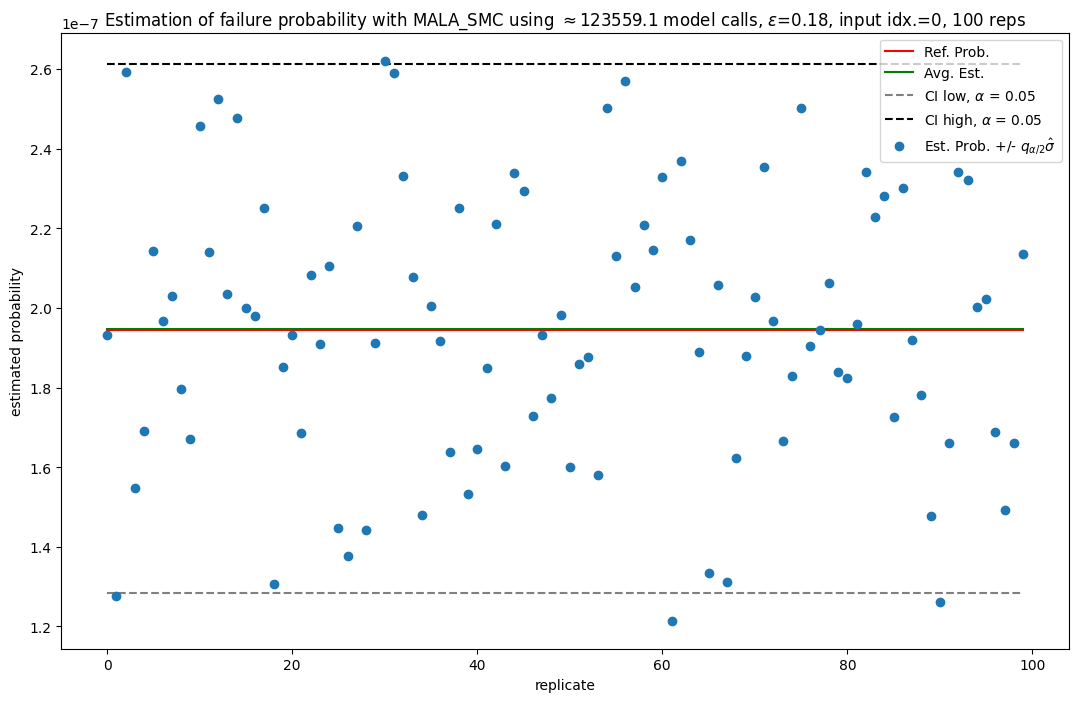

mean est:1.947763398391089e-07, std est:3.3910787382815905e-08
mean calls:123559.1
std. re.:893851.7050677764
std. rel. adj.:110443512211.6399
mean rel. error:0.14067106655076209
std rel. error:0.10307205941389559
stat performance (per 1k calls):12.735490896327468
p_fail_mala=1.947763398391089e-07


In [83]:
p_fail_mala, dict_out=run_exp.run_est(model=model,method='mala2',X=X,y=y,dataset_name='mnist',
                        n_rep=100, verbose=0, track_accept=False,ess_alpha_range=[0.875],
                        alpha=0.2, L_range=[1], adapt_func='simp_ess',p_ref=p_ref,
                         N_range=[500],T_range=[20],epsilon_range=epsilon_range,repeat_exp=True,
 )
exp_config,method_config_mala, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_df_mala = dict_out['results_df']
print(f"p_fail_mala={p_fail_mala}")

In [4]:
p_fail_form,dict_out_form = run_exp.run_est(model=model,method='form',X=X,y=y,dataset_name='mnist',
                    search_method='carlini',epsilon_range = epsilon_range,
                    steps_range=[1000,],num_iter_range=[10],stepsize_range=[1e-2],
                    repeat_exp=True, random_init=False, 
                    sigma_init=0.000001,
                        
                        
                        n_rep=1, verbose=0,p_ref=p_ref)

NameError: name 'model' is not defined

In [78]:
p_fail_mc, dict_out_mc = run_exp.run_est(model=model, method = 'CrudeMC',
            X=X, y=y, dataset_name='mnist',epsilon_range=epsilon_range,
            repeat_exp=True,n_rep=5, 
            N_range=[int(1e8)],batch_size_range=[int(4e5)],track_advs=False) 

with parameters in {'N_range': [100000000], 'batch_size_range': [400000]}
Starting CrudeMC simulation 1/1, with model: mnist_model, img_idx:0,eps:0.18,


 20%|██        | 1/5 [00:34<02:16, 34.19s/it]


KeyboardInterrupt: 

In [53]:
exp_config.model

dnn2(
  (linear1): Linear(in_features=784, out_features=200, bias=True)
  (linear2): Linear(in_features=200, out_features=10, bias=True)
  (flat_op): Flatten()
)

## 4. Analysis of Experiments

In [65]:
eps=0.18

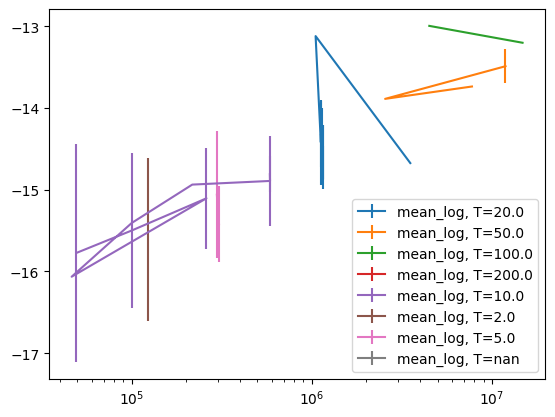

In [68]:
fig=plt.figure()
ax=plt.axes()
ax.set_xscale('log')
mls_webb_df=  utils.get_sel_df(df=agg_res_df,triplets=[('method_name','MALA_SMC','='),])
for T in agg_res_df['T'].unique():
    df = utils.get_sel_df(mls_webb_df,triplets=[('T',T,'='),('epsilon',eps,'=')])
    ax.errorbar(x=df['mean_calls'],y=df['mean_log_est'], yerr=df['std_log_est'],label=f'mean_log, T={T}',)
    ax.legend()

